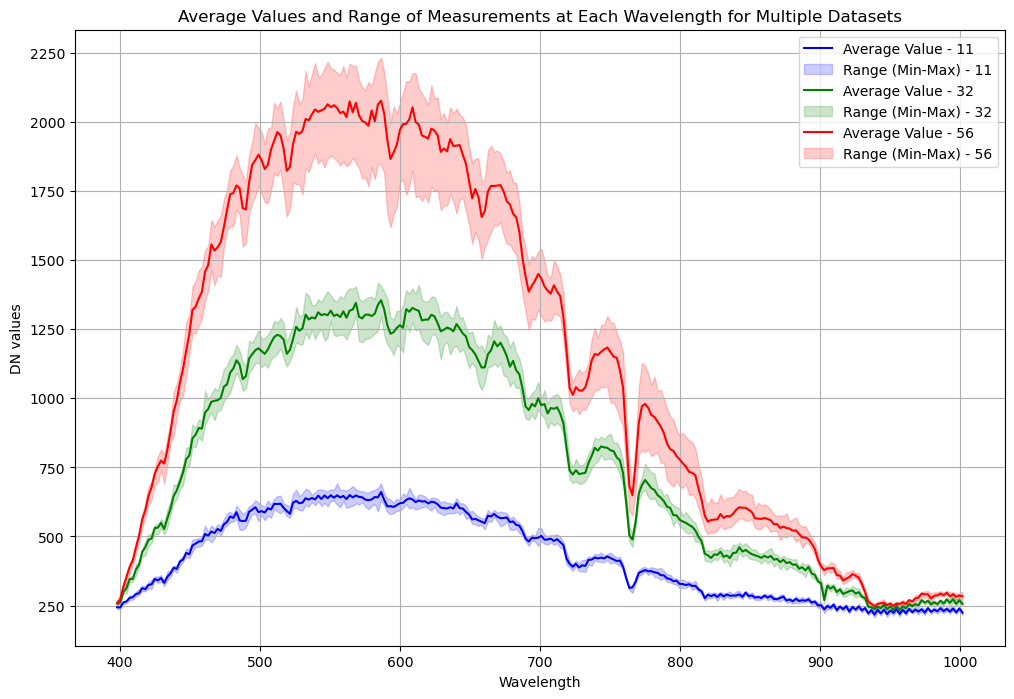

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File paths
file_paths = [
    'C:/Users/Say70/OneDrive - Mississippi State University/Desktop/UAS data collection/SurajTest/rawDN/30/4pm_30m_11.txt',
    'C:/Users/Say70/OneDrive - Mississippi State University/Desktop/UAS data collection/SurajTest/rawDN/30/4pm_30m_32.txt',
    'C:/Users/Say70/OneDrive - Mississippi State University/Desktop/UAS data collection/SurajTest/rawDN/30/4pm_30m_56.txt'
]

# Initialize lists to store data
wavelengths_list = []
average_values_list = []
max_values_list = []
min_values_list = []

# Process each file
for file_path in file_paths:
    # Read the data using pandas with updated parameter
    data = pd.read_csv(file_path, sep=r'\s+')
    
    # Rename columns to avoid issues like "Column.1", "Column.2"
    data.columns = [f'Column_{i+1}' for i in range(data.shape[1])]
    
    # Drop any columns with NaN values
    data = data.dropna(axis=1)
    
    # Calculate the average, max, and min values across all columns (excluding Column_1)
    average_values = data.iloc[:, 1:].mean(axis=1)
    max_values = data.iloc[:, 1:].max(axis=1)
    min_values = data.iloc[:, 1:].min(axis=1)
    wavelengths = data['Column_1']
    
    # Store the results in lists
    wavelengths_list.append(np.array(wavelengths))
    average_values_list.append(np.array(average_values))
    max_values_list.append(np.array(max_values))
    min_values_list.append(np.array(min_values))

# Plot all datasets
plt.figure(figsize=(12, 8))

colors = ['blue', 'green', 'red']  # Colors for different datasets
labels = ['11', '32', '56']  # Labels for different datasets

for i in range(len(file_paths)):
    plt.plot(wavelengths_list[i], average_values_list[i], color=colors[i], label=f'Average Value - {labels[i]}')
    plt.fill_between(wavelengths_list[i], min_values_list[i], max_values_list[i], color=colors[i], alpha=0.2, label=f'Range (Min-Max) - {labels[i]}')

# Customize the plot
plt.xlabel('Wavelength')
plt.ylabel('DN values')
plt.title('Average Values and Range of Measurements at Each Wavelength for Multiple Datasets')
plt.legend(loc='best')
plt.grid(True)

# Show the plot
plt.show()


In [2]:
DN_11=average_values_list[0]
DN_32=average_values_list[1]
DN_56=average_values_list[2]

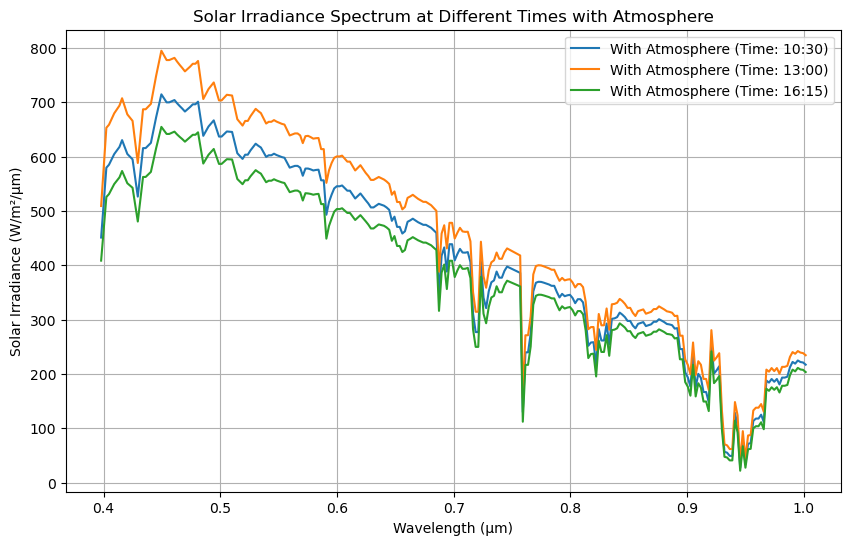

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import Py6S
from Py6S import *

# Initialize Py6S
s = Py6S.SixS()

# Define wavelengths
wavelengths = np.array(wavelengths_list[0]) * 1e-3

# Initialize lists to hold irradiance values
solar_irradiances_atmospheric = []

# Function to set up and run the simulation
def run_simulation(zenith, azimuth, atmospheric_profile, aerosol_profile=None, gas_absorption=None):
    s.geometry = Geometry.User()
    s.geometry.solar_z = zenith  # Set solar zenith angle
    s.geometry.solar_a = azimuth  # Set solar azimuth angle
    s.geometry.view_z = 0  # Set viewing zenith angle (0 for directly overhead)
    s.geometry.view_a = 0  # Set viewing azimuth angle
    s.atmos_profile = atmospheric_profile
    s.altitudes.set_sensor_custom_altitude(0.03)  # Sensor at ground level
    s.altitudes.set_target_sea_level()

    if aerosol_profile is not None:
        s.aerosols = aerosol_profile
    if gas_absorption is not None:
        s.gases = gas_absorption

    irradiance_values = []

    for wavelength in wavelengths:
        s.wavelength = Wavelength(wavelength)
        s.run()
        irradiance_values.append(s.outputs.diffuse_solar_irradiance)

    return irradiance_values

# Solar angles at different times
solar_angles = [
    (90-52.208845682026, 106.84977761202),  # At 10:30
    (90-73.214727727208, 179.1117845336),   # At 13:00
    (90-43.464829569984, 261.18327961148)   # At 16:15
]

# solar_angles = [
#     (52.208845682026, 106.84977761202),  # At 10:30
#     (73.214727727208, 179.1117845336),   # At 13:00
#     (43.464829569984, 261.18327961148)   # At 16:15
# ]

# Run simulations for each set of angles
for zenith, azimuth in solar_angles:
    solar_irradiances_atmospheric.append(run_simulation(zenith, azimuth, 
                                                          AtmosProfile.PredefinedType(AtmosProfile.MidlatitudeSummer)))

# Function to replace NaN values with average of neighboring values
def fill_nan_with_average(data):
    data_array = np.array(data)
    # Create a mask for NaN values
    nan_mask = np.isnan(data_array)
    
    # Calculate the average of the neighboring values
    for i in range(len(data_array)):
        if nan_mask[i]:
            # Get the neighboring values
            neighbors = []
            if i > 0 and not nan_mask[i - 1]:
                neighbors.append(data_array[i - 1])  # Previous value
            if i < len(data_array) - 1 and not nan_mask[i + 1]:
                neighbors.append(data_array[i + 1])  # Next value
            
            # Replace NaN with the average of neighbors if available
            if neighbors:
                data_array[i] = np.mean(neighbors)
    
    return data_array

# Plotting results for each time
plt.figure(figsize=(10, 6))
for idx, irradiance in enumerate(solar_irradiances_atmospheric):
    # Fill NaN values with the average of neighboring values
    filled_irradiance = fill_nan_with_average(irradiance)
    
    # Plot the filled values
    plt.plot(wavelengths, filled_irradiance, label=f"With Atmosphere (Time: {['10:30', '13:00', '16:15'][idx]})", color=f"C{idx}")

plt.xlabel("Wavelength (µm)")
plt.ylabel("Solar Irradiance (W/m²/µm)")
plt.title("Solar Irradiance Spectrum at Different Times with Atmosphere")
plt.legend()
plt.grid()

# Show the plot
plt.show()


In [4]:
import numpy as np

# Function to replace NaN values with the average of neighboring values
def fill_nan_with_average(data):
    data_array = np.array(data)
    nan_mask = np.isnan(data_array)
    
    for i in range(len(data_array)):
        if nan_mask[i]:  # If the value is NaN
            neighbors = []
            # Check previous value
            if i > 0 and not nan_mask[i - 1]:
                neighbors.append(data_array[i - 1])
            # Check next value
            if i < len(data_array) - 1 and not nan_mask[i + 1]:
                neighbors.append(data_array[i + 1])
            
            # Replace NaN with the average of neighbors if available
            if neighbors:
                data_array[i] = np.mean(neighbors)
    
    return data_array

# Fill NaN values for the first array in solar_irradiances_atmospheric
filled_array = fill_nan_with_average(solar_irradiances_atmospheric[2])
print("Filled Array:", filled_array)


Filled Array: [408.493  467.0585 525.624  530.892  540.119  549.41   555.546  561.682
 573.43   562.121  550.899  546.682  542.533  511.458  480.455  521.448
 562.455  562.455  567.085  571.774  593.892  615.382  634.958  654.593
 648.088  641.585  641.585  643.691  645.853  640.64   636.168  632.064
 627.401  631.557  635.483  640.064  640.064  644.607  615.738  587.11
 595.303  603.282  608.62   613.936  600.154  586.488  586.488  590.807
 595.148  594.855  594.624  576.634  558.702  553.947  549.135  556.33
 556.33   563.486  569.295  574.962  571.489  568.537  560.622  552.755
 555.548  555.548  558.218  555.952  554.214  552.476  551.32   542.858
 534.448  535.886  537.385  537.385  534.27   519.079  532.539  532.135
 531.229  529.742  530.779  531.335  512.504  512.504  448.955  472.254
 485.767  498.547  503.515  503.237  504.836  500.517  496.226  496.226
 489.761  483.289  487.802  492.195  486.564  480.93   474.942  467.637
 467.637  471.366  475.095  473.788  472.579  469.49

In [5]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt

# # File paths
# file_paths = [
#     'C:/Users/Say70/OneDrive - Mississippi State University/Desktop/UAS data collection/SurajTest/10AM/Ref_12.txt',
#     'C:/Users/Say70/OneDrive - Mississippi State University/Desktop/UAS data collection/SurajTest/10AM/Ref_32.txt',
#     'C:/Users/Say70/OneDrive - Mississippi State University/Desktop/UAS data collection/SurajTest/10AM/Ref_56.txt',
# ]

# # Initialize lists to store data
# wavelengths_list = []
# average_ref_values_list = []
# max_ref_values_list = []
# min_ref_values_list = []

# # Process each file
# for file_path in file_paths:
#     # Read the data using pandas with updated parameter
#     data = pd.read_csv(file_path, sep=r'\s+')
    
#     # Rename columns to avoid issues like "Column.1", "Column.2"
#     data.columns = [f'Column_{i+1}' for i in range(data.shape[1])]
    
#     # Drop any columns with NaN values
#     data = data.dropna(axis=1)
    
#     # Calculate the average, max, and min values across all columns (excluding Column_1)
#     average_ref_values = data.iloc[:, 1:].mean(axis=1)
#     max_ref_values = data.iloc[:, 1:].max(axis=1)
#     min_ref_values = data.iloc[:, 1:].min(axis=1)
#     wavelengths = data['Column_1']
    
#     # Store the results in lists
#     wavelengths_list.append(np.array(wavelengths))
#     average_ref_values_list.append(np.array(average_ref_values))
#     max_ref_values_list.append(np.array(max_ref_values))
#     min_ref_values_list.append(np.array(min_ref_values))

# # Plot all datasets
# plt.figure(figsize=(12, 8))

# colors = ['blue', 'green', 'red']  # Colors for different datasets
# labels = ['Dataset 1', 'Dataset 2', 'Dataset 3']  # Labels for different datasets

# for i in range(len(file_paths)):
#     plt.plot(wavelengths_list[i], average_ref_values_list[i], color=colors[i], label=f'Average ref values - {labels[i]}')
#     plt.fill_between(wavelengths_list[i], min_ref_values_list[i], max_ref_values_list[i], color=colors[i], alpha=0.2, label=f'Range (Min-Max) - {labels[i]}')

# # Customize the plot
# plt.xlabel('Wavelength')
# plt.ylabel('Reflectivity values')
# plt.title('Average Values and Range of Measurements at Each Wavelength for Multiple Datasets')
# plt.legend(loc='best')
# plt.grid(True)

# # Show the plot
# plt.show()


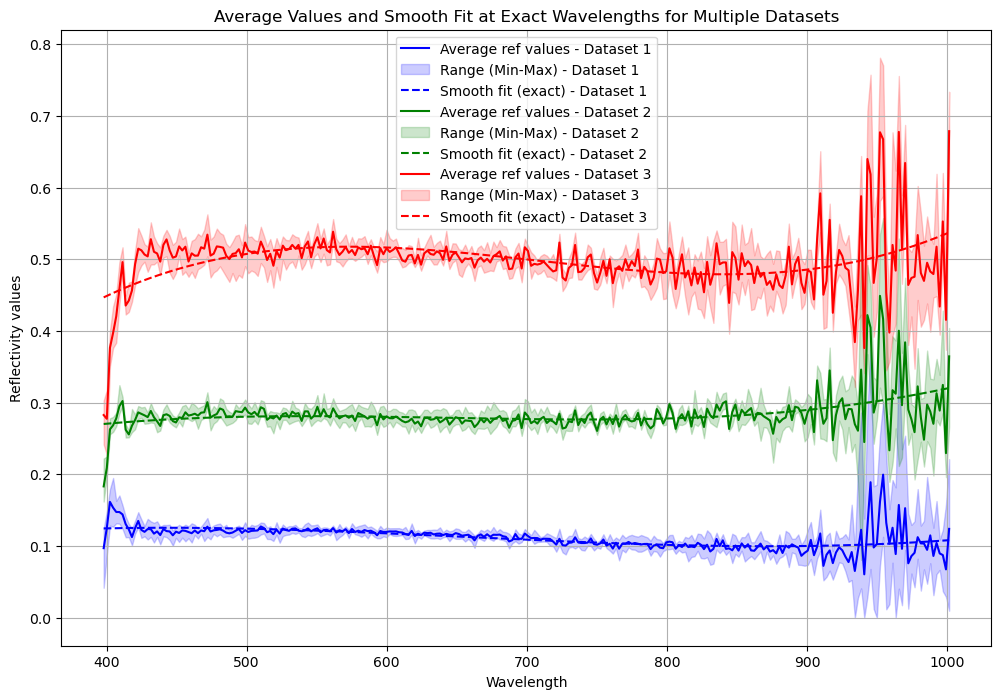

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline

# File paths
file_paths = [
    'C:/Users/Say70/OneDrive - Mississippi State University/Desktop/UAS data collection/SurajTest/rawDN/30/ref_4pm_11.txt',
    'C:/Users/Say70/OneDrive - Mississippi State University/Desktop/UAS data collection/SurajTest/rawDN/30/ref_4pm_32.txt',
    'C:/Users/Say70/OneDrive - Mississippi State University/Desktop/UAS data collection/SurajTest/rawDN/30/ref_4pm_56.txt'
]

# Initialize lists to store data
wavelengths_list = []
average_ref_values_list = []
max_ref_values_list = []
min_ref_values_list = []
smooth_fits_exact_list = []  # To store smooth values at exact wavelengths

# Process each file
for file_path in file_paths:
    # Read the data using pandas with updated parameter
    data = pd.read_csv(file_path, sep=r'\s+')
    
    # Rename columns to avoid issues like "Column.1", "Column.2"
    data.columns = [f'Column_{i+1}' for i in range(data.shape[1])]
    
    # Drop any columns with NaN values
    data = data.dropna(axis=1)
    
    # Calculate the average, max, and min values across all columns (excluding Column_1)
    average_ref_values = data.iloc[:, 1:].mean(axis=1)
    max_ref_values = data.iloc[:, 1:].max(axis=1)
    min_ref_values = data.iloc[:, 1:].min(axis=1)
    wavelengths = data['Column_1']
    
    # Store the results in lists
    wavelengths_list.append(np.array(wavelengths))
    average_ref_values_list.append(np.array(average_ref_values))
    max_ref_values_list.append(np.array(max_ref_values))
    min_ref_values_list.append(np.array(min_ref_values))

# Generate smooth fit for each dataset at exact wavelengths
for i in range(len(file_paths)):
    # Create a smooth spline fit for the average reflectivity values
    spline = UnivariateSpline(wavelengths_list[i], average_ref_values_list[i], s=1)  # s is the smoothing factor
    
    # Calculate the smooth fit exactly at the given wavelengths
    smooth_values_exact = spline(wavelengths_list[i])
    
    # Store smooth fit values at exact wavelengths in the list
    smooth_fits_exact_list.append(np.array(smooth_values_exact))

# Now, `smooth_fits_exact_list` contains smooth fit arrays at exact wavelengths for each dataset

# Optional: Plot all datasets with smooth fits
plt.figure(figsize=(12, 8))

colors = ['blue', 'green', 'red']  # Colors for different datasets
labels = ['Dataset 1', 'Dataset 2', 'Dataset 3']  # Labels for different datasets

for i in range(len(file_paths)):
    # Plot original data
    plt.plot(wavelengths_list[i], average_ref_values_list[i], color=colors[i], label=f'Average ref values - {labels[i]}')
    plt.fill_between(wavelengths_list[i], min_ref_values_list[i], max_ref_values_list[i], color=colors[i], alpha=0.2, label=f'Range (Min-Max) - {labels[i]}')
    
    # Plot the smooth fit at exact wavelengths
    plt.plot(wavelengths_list[i], smooth_fits_exact_list[i], color=colors[i], linestyle='--', label=f'Smooth fit (exact) - {labels[i]}')

# Customize the plot
plt.xlabel('Wavelength')
plt.ylabel('Reflectivity values')
plt.title('Average Values and Smooth Fit at Exact Wavelengths for Multiple Datasets')
plt.legend(loc='best')
plt.grid(True)

# Show the plot
plt.show()


In [7]:
# Create a reflectance array with 0.11 for each wavelength
# r_11 = np.full_like(wavelengths, 0.11)
# r_32 = np.full_like(wavelengths, 0.32)
# r_56 = np.full_like(wavelengths, 0.56)


# r_11 = smooth_fits_exact_list[0]
# r_32 = smooth_fits_exact_list[1]
# r_56 = smooth_fits_exact_list[2]

r_11 = average_ref_values_list[0]
r_32 = average_ref_values_list[1]
r_56 = average_ref_values_list[2]

# import pandas as pd

# # Read the CSV file into a DataFrame
# df = pd.read_csv('C:/Users/Say70/OneDrive - Mississippi State University/Desktop/UAS data collection/SurajTest/interpolated_average_reflectance.csv')

# # Extract the reflectance columns into arrays
# r_11 = df['Avg_Reflectance_11'].values/100
# r_32 = df['Avg_Reflectance_32'].values/100
# r_56 = df['Avg_Reflectance_56'].values/100




# print(r_11.shape)



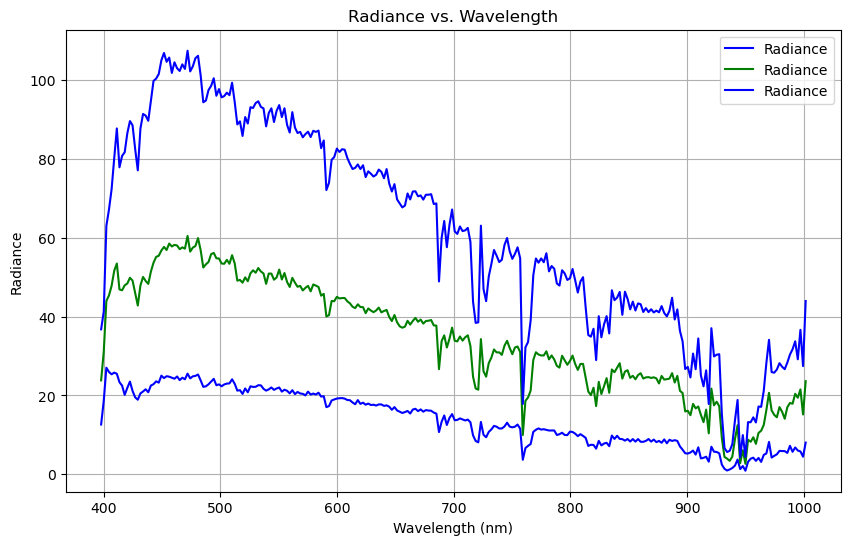

In [8]:
import numpy as np
import matplotlib.pyplot as plt


#ground_irradiances = np.nan_to_num(ground_irradiances, nan=0.0)

# rad_11 = (r_11 * target_irradiance_270)/np.pi
# rad_32 = (r_32 * target_irradiance_270)/np.pi
# rad_56 = (r_56 * target_irradiance_270)/np.pi

rad_11 = (r_11 * filled_array)/np.pi
rad_32 = (r_32 * filled_array)/np.pi
rad_56 = (r_56 * filled_array)/np.pi

# rad_11 = (r_11 * (ground_irradiances))/np.pi
# rad_32 = (r_32 * (ground_irradiances))/np.pi
# rad_56 = (r_56 * (ground_irradiances))/np.pi

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(wavelengths, rad_11, label='Radiance', color='b')
plt.plot(wavelengths, rad_32, label='Radiance', color='g')
plt.plot(wavelengths, rad_56, label='Radiance', color='b')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Radiance')
plt.title('Radiance vs. Wavelength')
plt.grid(True)
plt.legend()
plt.show()


In [9]:
print(DN_11.shape)
print(DN_32.shape)
print(DN_56.shape)
print(rad_11.shape)
print(rad_32.shape)
print(rad_56.shape)
# Debugging: Check the shapes of DN and rad arrays
print("DN_11 shape:", DN_11.shape)
print("DN_32 shape:", DN_32.shape)
print("DN_56 shape:", DN_56.shape)
print("rad_11 shape:", rad_11.shape)
print("rad_32 shape:", rad_32.shape)
print("rad_56 shape:", rad_56.shape)

# Ensure that all arrays are initialized properly and have 270 elements
if DN_11.shape[0] != 270 or DN_32.shape[0] != 270 or DN_56.shape[0] != 270:
    print("Error: DN arrays do not have 270 elements.")
if rad_11.shape[0] != 270 or rad_32.shape[0] != 270 or rad_56.shape[0] != 270:
    print("Error: Radiance arrays do not have 270 elements.")


(270,)
(270,)
(270,)
(270,)
(270,)
(270,)
DN_11 shape: (270,)
DN_32 shape: (270,)
DN_56 shape: (270,)
rad_11 shape: (270,)
rad_32 shape: (270,)
rad_56 shape: (270,)


gain_offset_cubic_10am.csv saved


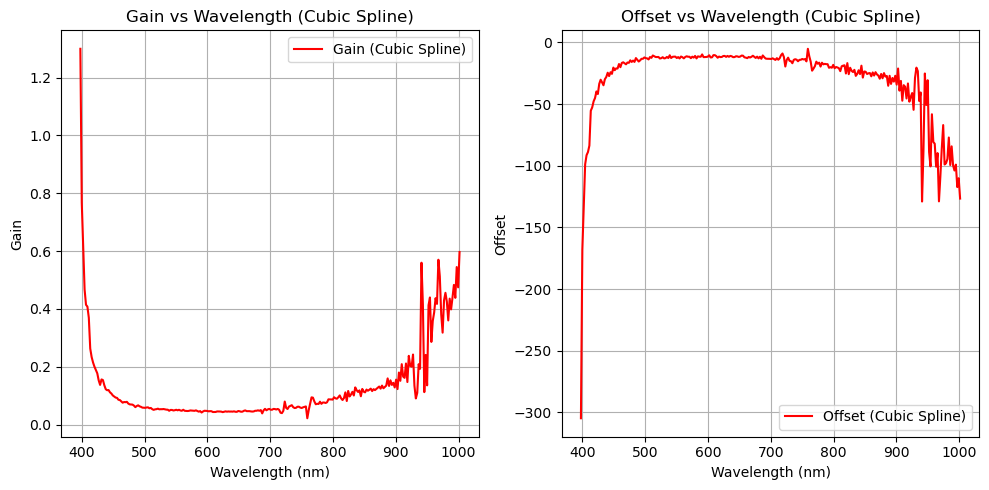

In [10]:
import numpy as np
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt
import pandas as pd

# Initialize arrays for gain and offset for cubic spline interpolation
gain_cubic = np.zeros(270)
offset_cubic = np.zeros(270)

# Solve for each band using cubic spline interpolation
for i in range(270):
    # Define DN and radiance values for the current iteration
    DN_values = np.array([DN_11[i], DN_32[i], DN_56[i]])
    radiance_values = np.array([rad_11[i], rad_32[i], rad_56[i]])

    # Cubic spline interpolation
    cubic_spline = CubicSpline(DN_values, radiance_values)
    radiance_interpolated_cubic = cubic_spline(DN_values)

    # Solve for gain and offset using cubic spline interpolation
    A = np.vstack([DN_values, np.ones_like(DN_values)]).T
    x_cubic, residuals, rank, s = np.linalg.lstsq(A, radiance_interpolated_cubic, rcond=None)
    gain_cubic[i] = x_cubic[0]
    offset_cubic[i] = x_cubic[1]

# Create a DataFrame to store the wavelength, gain, and offset values
df = pd.DataFrame({
    'Wavelength (nm)': wavelengths,  # Ensure 'wavelengths' is defined
    'Gain (Cubic)': gain_cubic,
    'Offset (Cubic)': offset_cubic
})

# Save the DataFrame to a CSV file
df.to_csv('C:/Users/Say70/OneDrive - Mississippi State University/Desktop/UAS data collection/SurajTest/psr_gain_offset_cubic_4pm.csv', index=False)
print("gain_offset_cubic_10am.csv saved")

# Plotting Gain and Offset vs Wavelength using Cubic Spline Interpolation
plt.figure(figsize=(10, 5))

# Plot Gain
plt.subplot(1, 2, 1)
plt.plot(wavelengths, gain_cubic, label='Gain (Cubic Spline)', color='r', linestyle='-')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Gain')
plt.title('Gain vs Wavelength (Cubic Spline)')
plt.legend()
plt.grid(True)

# Plot Offset
plt.subplot(1, 2, 2)
plt.plot(wavelengths, offset_cubic, label='Offset (Cubic Spline)', color='r', linestyle='-')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Offset')
plt.title('Offset vs Wavelength (Cubic Spline)')
plt.legend()
plt.grid(True)

# Show the plots
plt.tight_layout()
plt.show()


In [11]:
# import pandas as pd
# import matplotlib.pyplot as plt

# # Paths to the CSV files
# file_path_1 = 'C:/Users/Say70/OneDrive - Mississippi State University/Desktop/UAS data collection/SurajTest/gain_offset_cubic_10am.csv'
# file_path_2 = 'C:/Users/Say70/OneDrive - Mississippi State University/Desktop/UAS data collection/SurajTest/gain_offset_cubic_1pm.csv'
# file_path_3 = 'C:/Users/Say70/OneDrive - Mississippi State University/Desktop/UAS data collection/SurajTest/gain_offset_cubic_4pm.csv'

# # Read the CSV files into DataFrames
# df_1 = pd.read_csv(file_path_1)
# df_2 = pd.read_csv(file_path_2)
# df_3 = pd.read_csv(file_path_3)


# # Combine data for gain and offset calculations
# wavelength = df_1['Wavelength (nm)']  # Assuming wavelengths are identical across datasets
# gain_values = pd.concat([df_1['Gain (Cubic)'], df_2['Gain (Cubic)'], df_3['Gain (Cubic)']], axis=1)
# offset_values = pd.concat([df_1['Offset (Cubic)'], df_2['Offset (Cubic)'], df_3['Offset (Cubic)']], axis=1)

# # Calculate min, max, and average for gain and offset
# gain_min = gain_values.min(axis=1)
# gain_max = gain_values.max(axis=1)
# gain_avg = gain_values.mean(axis=1)
# offset_min = offset_values.min(axis=1)
# offset_max = offset_values.max(axis=1)
# offset_avg = offset_values.mean(axis=1)

# # Convert average gain and offset to arrays
# gain_cubic = gain_avg.values
# offset_cubic = offset_avg.values

# # Plot Wavelength vs Gain with min, max, and average
# plt.figure(figsize=(10, 6))
# plt.plot(wavelength, gain_min, color='blue', alpha=0.2, label='Gain Min')
# plt.plot(wavelength, gain_max, color='blue', alpha=0.2, label='Gain Max')
# plt.plot(wavelength, gain_avg, color='blue', label='Gain Average')
# plt.fill_between(wavelength, gain_min, gain_max, color='blue', alpha=0.1)  # Shaded area for range
# plt.xlabel('Wavelength (nm)')
# plt.ylabel('Gain (Cubic)')
# plt.title('Wavelength vs Gain (Min, Max, Average)')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# # Plot Wavelength vs Offset with min, max, and average
# plt.figure(figsize=(10, 6))
# plt.plot(wavelength, offset_min, color='red', alpha=0.2, label='Offset Min')
# plt.plot(wavelength, offset_max, color='red', alpha=0.2, label='Offset Max')
# plt.plot(wavelength, offset_avg, color='red', label='Offset Average')
# plt.fill_between(wavelength, offset_min, offset_max, color='red', alpha=0.1)  # Shaded area for range
# plt.xlabel('Wavelength (nm)')
# plt.ylabel('Offset (Cubic)')
# plt.title('Wavelength vs Offset (Min, Max, Average)')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# # Display the arrays
# print("Average Gain Array:", gain_cubic .shape)
# print("Average Offset Array:", offset_cubic .shape)


C:\Users\Say70\AppData\Local\Temp\ipykernel_7660\606614880.py:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(file_path, delim_whitespace=True)


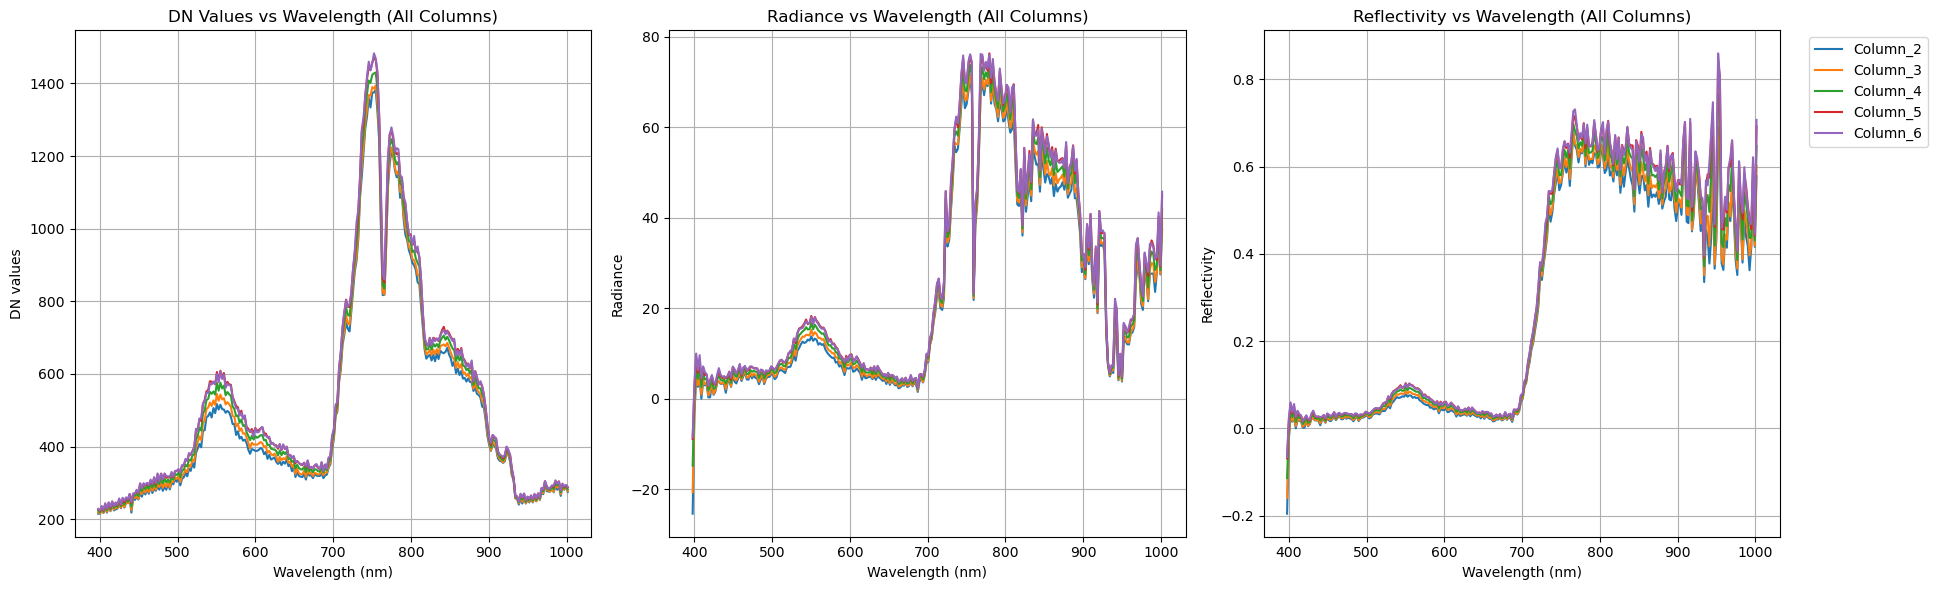

Reflectivity Array Shape: (5, 270)


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define the file path
file_path = 'C:/Users/Say70/OneDrive - Mississippi State University/Desktop/UAS data collection/SurajTest/rawDN/30/veg_4pm_spec.txt'


# Read the data using pandas
data = pd.read_csv(file_path, delim_whitespace=True)

# Rename columns to avoid issues like "Column.1", "Column.2"
data.columns = [f'Column_{i+1}' for i in range(data.shape[1])]

# Drop any columns with NaN values
data = data.dropna(axis=1)

# Extract wavelengths
wavelengths = data['Column_1']

# Initialize an empty list to store reflectivity values for each column
reflectivity_veg = []

# Create figure for all DN, radiance, and reflectivity plots
plt.figure(figsize=(18, 6))

# Plot DN values for all columns in the same plot
plt.subplot(1, 3, 1)
for col in data.columns[1:]:
    DN_values = data[col].to_numpy()
    plt.plot(wavelengths, DN_values, label=f'{col}')
plt.xlabel('Wavelength (nm)')
plt.ylabel('DN values')
plt.title('DN Values vs Wavelength (All Columns)')
plt.grid(True)

# Plot Radiance values for all columns in the same plot
plt.subplot(1, 3, 2)
for col in data.columns[1:]:
    DN_values = data[col].to_numpy()
    # Calculate vegetation radiance using gain and offset
    veg_rad = gain_cubic * DN_values + offset_cubic
    plt.plot(wavelengths, veg_rad, label=f'{col}')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Radiance')
plt.title('Radiance vs Wavelength (All Columns)')
plt.grid(True)

# Plot Reflectivity values for all columns in the same plot and store in array
plt.subplot(1, 3, 3)
for col in data.columns[1:]:
    DN_values = data[col].to_numpy()
    # Calculate vegetation radiance using gain and offset
    veg_rad = gain_cubic * DN_values + offset_cubic
    # Calculate reflectivity
    ref_veg = np.pi * veg_rad / filled_array
    reflectivity_veg.append(ref_veg)  # Store reflectivity in the array
    plt.plot(wavelengths, ref_veg, label=f'{col}')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflectivity')
plt.title('Reflectivity vs Wavelength (All Columns)')
plt.grid(True)

# Show the final plots with legends
plt.tight_layout()
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1), ncol=1)
plt.show()

# Convert the reflectivity list to a numpy array for easier manipulation later
reflectivity_veg = np.array(reflectivity_veg)

# Optionally print or save the reflectivity array for further analysis
print("Reflectivity Array Shape:", reflectivity_veg.shape)


In [13]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt

# # Define the file path

# file_path = 'C:/Users/Say70/OneDrive - Mississippi State University/Desktop/UAS data collection/SurajTest/rawDN/30/grass_10am.txt'


# # Read the data using pandas
# data = pd.read_csv(file_path, delim_whitespace=True)

# # Rename columns to avoid issues like "Column.1", "Column.2"
# data.columns = [f'Column_{i+1}' for i in range(data.shape[1])]

# # Drop any columns with NaN values
# data = data.dropna(axis=1)

# # Extract wavelengths
# wavelengths = data['Column_1']

# # Initialize an empty list to store reflectivity values for each column
# reflectivity_grass = []

# # Create figure for all DN, radiance, and reflectivity plots
# plt.figure(figsize=(18, 6))

# # Plot DN values for all columns in the same plot
# plt.subplot(1, 3, 1)
# for col in data.columns[1:]:
#     DN_values = data[col].to_numpy()
#     plt.plot(wavelengths, DN_values, label=f'{col}')
# plt.xlabel('Wavelength (nm)')
# plt.ylabel('DN values')
# plt.title('DN Values vs Wavelength (All Columns)')
# plt.grid(True)

# # Plot Radiance values for all columns in the same plot
# plt.subplot(1, 3, 2)
# for col in data.columns[1:]:
#     DN_values = data[col].to_numpy()
#     # Calculate vegetation radiance using gain and offset
#     veg_rad = gain_cubic * DN_values + offset_cubic
#     plt.plot(wavelengths, veg_rad, label=f'{col}')
# plt.xlabel('Wavelength (nm)')
# plt.ylabel('Radiance')
# plt.title('Radiance vs Wavelength (All Columns)')
# plt.grid(True)

# # Plot Reflectivity values for all columns in the same plot and store in array
# plt.subplot(1, 3, 3)
# for col in data.columns[1:]:
#     DN_values = data[col].to_numpy()
#     # Calculate vegetation radiance using gain and offset
#     veg_rad = gain_cubic * DN_values + offset_cubic
#     # Calculate reflectivity
#     ref_veg = np.pi * veg_rad / filled_array
#     reflectivity_grass.append(ref_veg)  # Store reflectivity in the array
#     plt.plot(wavelengths, ref_veg, label=f'{col}')
# plt.xlabel('Wavelength (nm)')
# plt.ylabel('Reflectivity')
# plt.title('Reflectivity vs Wavelength (All Columns)')
# plt.grid(True)

# # Show the final plots with legends
# plt.tight_layout()
# plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1), ncol=1)
# plt.show()

# # Convert the reflectivity list to a numpy array for easier manipulation later
# reflectivity_grass = np.array(reflectivity_grass)


# # Optionally print or save the reflectivity array for further analysis
# print("Reflectivity Array Shape:", reflectivity_grass.shape)


In [14]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt

# # Define the file path
# file_path = 'C:/Users/Say70/OneDrive - Mississippi State University/Desktop/UAS data collection/SurajTest/rawDN/30/road_10am.txt'

# # Read the data using pandas
# data = pd.read_csv(file_path, delim_whitespace=True)

# # Rename columns to avoid issues like "Column.1", "Column.2"
# data.columns = [f'Column_{i+1}' for i in range(data.shape[1])]

# # Drop any columns with NaN values
# data = data.dropna(axis=1)

# # Extract wavelengths
# wavelengths = data['Column_1']

# # Initialize an empty list to store reflectivity values for each column
# reflectivity_road = []

# # Create figure for all DN, radiance, and reflectivity plots
# plt.figure(figsize=(18, 6))

# # Plot DN values for all columns in the same plot
# plt.subplot(1, 3, 1)
# for col in data.columns[1:]:
#     DN_values = data[col].to_numpy()
#     plt.plot(wavelengths, DN_values, label=f'{col}')
# plt.xlabel('Wavelength (nm)')
# plt.ylabel('DN values')
# plt.title('DN Values vs Wavelength (All Columns)')
# plt.grid(True)

# # Plot Radiance values for all columns in the same plot
# plt.subplot(1, 3, 2)
# for col in data.columns[1:]:
#     DN_values = data[col].to_numpy()
#     # Calculate vegetation radiance using gain and offset
#     veg_rad = gain_cubic * DN_values + offset_cubic
#     plt.plot(wavelengths, veg_rad, label=f'{col}')
# plt.xlabel('Wavelength (nm)')
# plt.ylabel('Radiance')
# plt.title('Radiance vs Wavelength (All Columns)')
# plt.grid(True)

# # Plot Reflectivity values for all columns in the same plot and store in array
# plt.subplot(1, 3, 3)
# for col in data.columns[1:]:
#     DN_values = data[col].to_numpy()
#     # Calculate vegetation radiance using gain and offset
#     veg_rad = gain_cubic * DN_values + offset_cubic
#     # Calculate reflectivity
#     ref_veg = np.pi * veg_rad / filled_array
#     reflectivity_road.append(ref_veg)  # Store reflectivity in the array
#     plt.plot(wavelengths, ref_veg, label=f'{col}')
# plt.xlabel('Wavelength (nm)')
# plt.ylabel('Reflectivity')
# plt.title('Reflectivity vs Wavelength (All Columns)')
# plt.grid(True)

# # Show the final plots with legends
# plt.tight_layout()
# plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1), ncol=1)
# plt.show()

# # Convert the reflectivity list to a numpy array for easier manipulation later
# reflectivity_road = np.array(reflectivity_road)


# # Optionally print or save the reflectivity array for further analysis
# print("Reflectivity Array Shape:", reflectivity_road.shape)


C:\Users\Say70\AppData\Local\Temp\ipykernel_7660\1623658035.py:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(file_path, delim_whitespace=True)


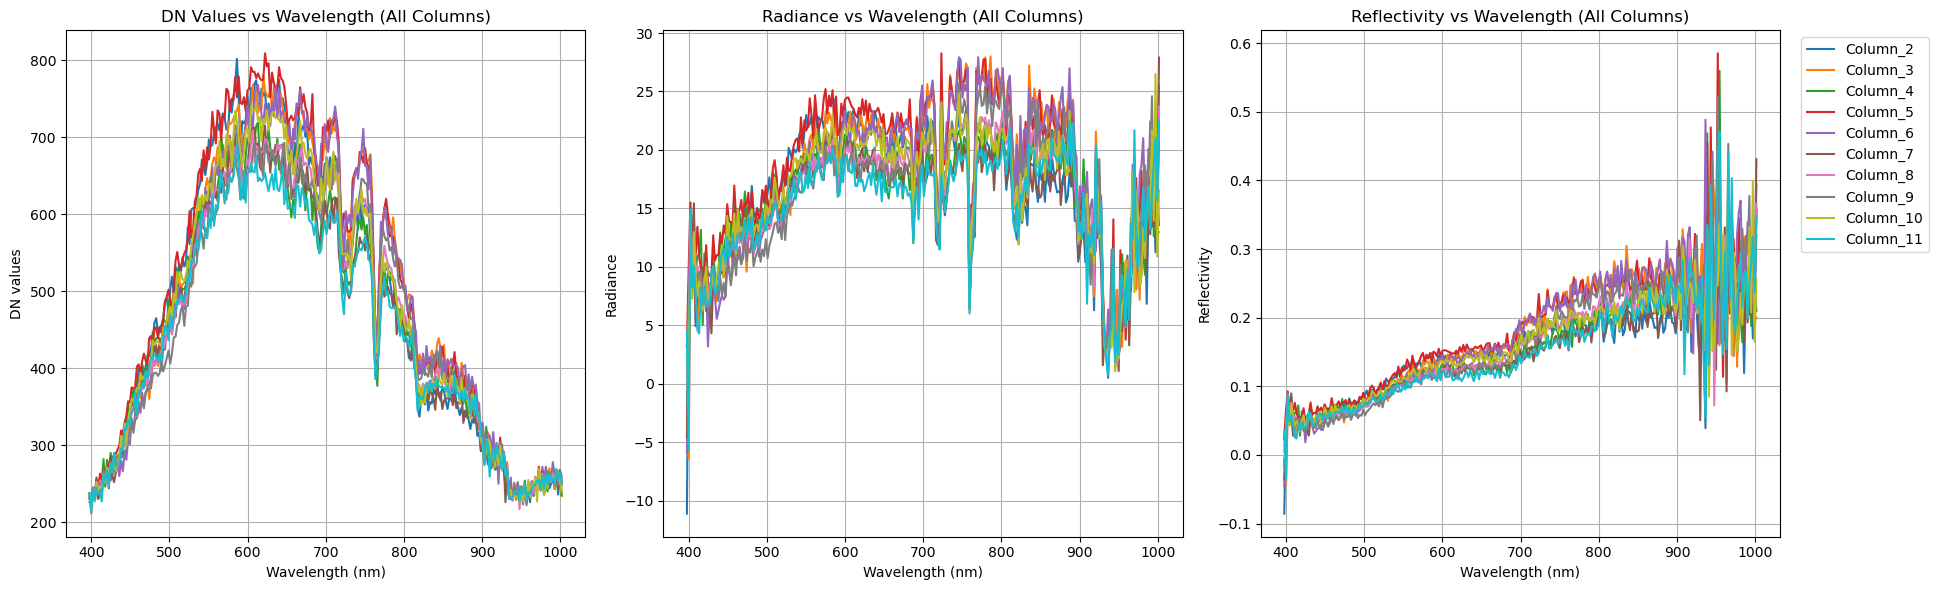

Reflectivity Array Shape: (10, 270)


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define the file path
file_path = 'C:/Users/Say70/OneDrive - Mississippi State University/Desktop/UAS data collection/SurajTest/rawDN/30/soil_4pm.txt'

# Read the data using pandas
data = pd.read_csv(file_path, delim_whitespace=True)

# Rename columns to avoid issues like "Column.1", "Column.2"
data.columns = [f'Column_{i+1}' for i in range(data.shape[1])]

# Drop any columns with NaN values
data = data.dropna(axis=1)

# Extract wavelengths
wavelengths = data['Column_1']

# Initialize an empty list to store reflectivity values for each column
reflectivity_soil = []

# Create figure for all DN, radiance, and reflectivity plots
plt.figure(figsize=(18, 6))

# Plot DN values for all columns in the same plot
plt.subplot(1, 3, 1)
for col in data.columns[1:]:
    DN_values = data[col].to_numpy()
    plt.plot(wavelengths, DN_values, label=f'{col}')
plt.xlabel('Wavelength (nm)')
plt.ylabel('DN values')
plt.title('DN Values vs Wavelength (All Columns)')
plt.grid(True)

# Plot Radiance values for all columns in the same plot
plt.subplot(1, 3, 2)
for col in data.columns[1:]:
    DN_values = data[col].to_numpy()
    # Calculate vegetation radiance using gain and offset
    veg_rad = gain_cubic * DN_values + offset_cubic
    plt.plot(wavelengths, veg_rad, label=f'{col}')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Radiance')
plt.title('Radiance vs Wavelength (All Columns)')
plt.grid(True)

# Plot Reflectivity values for all columns in the same plot and store in array
plt.subplot(1, 3, 3)
for col in data.columns[1:]:
    DN_values = data[col].to_numpy()
    # Calculate vegetation radiance using gain and offset
    veg_rad = gain_cubic * DN_values + offset_cubic
    # Calculate reflectivity
    ref_soil = np.pi * veg_rad / filled_array
    reflectivity_soil.append(ref_soil)  # Store reflectivity in the array
    plt.plot(wavelengths, ref_soil, label=f'{col}')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflectivity')
plt.title('Reflectivity vs Wavelength (All Columns)')
plt.grid(True)

# Show the final plots with legends
plt.tight_layout()
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1), ncol=1)
plt.show()

# Convert the reflectivity list to a numpy array for easier manipulation later
reflectivity_soil = np.array(reflectivity_soil)


# Optionally print or save the reflectivity array for further analysis
print("Reflectivity Array Shape:", reflectivity_soil.shape)


C:\Users\Say70\AppData\Local\Temp\ipykernel_7660\3186158253.py:11: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(file_path, delim_whitespace=True)


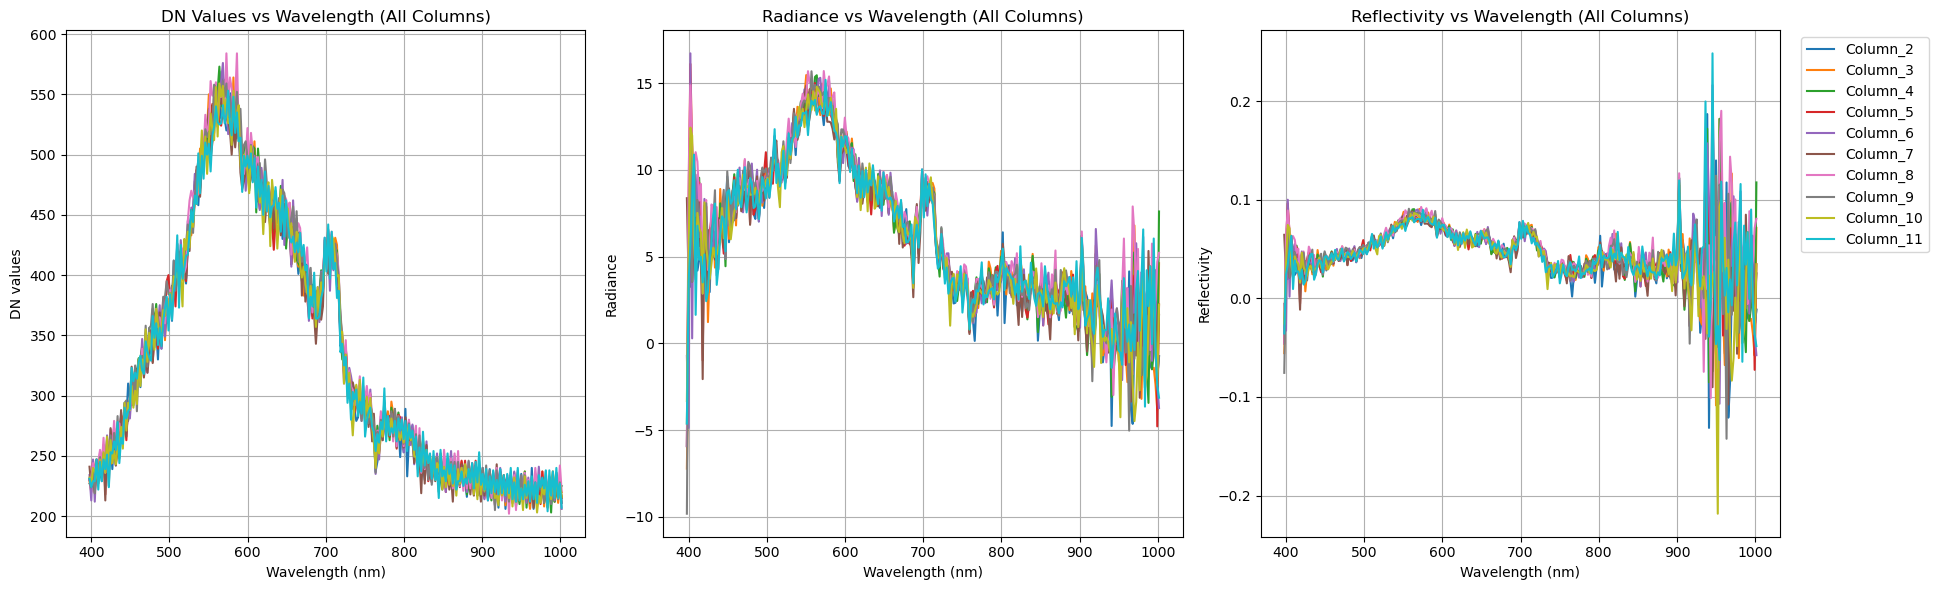

Reflectivity Array Shape: (10, 270)


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define the file path

file_path ='C:/Users/Say70/OneDrive - Mississippi State University/Desktop/UAS data collection/SurajTest/rawDN/30/water_4pm.txt'


# Read the data using pandas
data = pd.read_csv(file_path, delim_whitespace=True)

# Rename columns to avoid issues like "Column.1", "Column.2"
data.columns = [f'Column_{i+1}' for i in range(data.shape[1])]

# Drop any columns with NaN values
data = data.dropna(axis=1)

# Extract wavelengths
wavelengths = data['Column_1']

# Initialize an empty list to store reflectivity values for each column
reflectivity_water = []

# Create figure for all DN, radiance, and reflectivity plots
plt.figure(figsize=(18, 6))

# Plot DN values for all columns in the same plot
plt.subplot(1, 3, 1)
for col in data.columns[1:]:
    DN_values = data[col].to_numpy()
    plt.plot(wavelengths, DN_values, label=f'{col}')
plt.xlabel('Wavelength (nm)')
plt.ylabel('DN values')
plt.title('DN Values vs Wavelength (All Columns)')
plt.grid(True)

# Plot Radiance values for all columns in the same plot
plt.subplot(1, 3, 2)
for col in data.columns[1:]:
    DN_values = data[col].to_numpy()
    # Calculate vegetation radiance using gain and offset
    veg_rad = gain_cubic * DN_values + offset_cubic
    plt.plot(wavelengths, veg_rad, label=f'{col}')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Radiance')
plt.title('Radiance vs Wavelength (All Columns)')
plt.grid(True)

# Plot Reflectivity values for all columns in the same plot and store in array
plt.subplot(1, 3, 3)
for col in data.columns[1:]:
    DN_values = data[col].to_numpy()
    # Calculate vegetation radiance using gain and offset
    veg_rad = gain_cubic * DN_values + offset_cubic
    # Calculate reflectivity
    ref_veg = np.pi * veg_rad / filled_array
    reflectivity_water.append(ref_veg)  # Store reflectivity in the array
    plt.plot(wavelengths, ref_veg, label=f'{col}')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflectivity')
plt.title('Reflectivity vs Wavelength (All Columns)')
plt.grid(True)

# Show the final plots with legends
plt.tight_layout()
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1), ncol=1)
plt.show()

# Convert the reflectivity list to a numpy array for easier manipulation later
reflectivity_water = np.array(reflectivity_water)


# Optionally print or save the reflectivity array for further analysis
print("Reflectivity Array Shape:", reflectivity_water.shape)


In [45]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares

# Li-Sparse and Li-Dense Kernel (geometric scattering)
def li_geometric(theta_s, theta_v, phi, dense=False):
    theta_s_prime = np.arctan(np.tan(theta_s))
    theta_v_prime = np.arctan(np.tan(theta_v)) 
    cos_theta_s_prime = np.cos(theta_s_prime)
    cos_theta_v_prime = np.cos(theta_v_prime)
    sin_theta_s_prime = np.sin(theta_s_prime)
    sin_theta_v_prime = np.sin(theta_v_prime)
    cos_phi = np.cos(phi)
    cos_zeta_prime = (cos_theta_s_prime * cos_theta_v_prime) + (sin_theta_s_prime * sin_theta_v_prime * cos_phi)
    D = np.sqrt(np.tan(theta_s_prime)**2 + np.tan(theta_v_prime)**2 - 
                 2 * np.tan(theta_s_prime) * np.tan(theta_v_prime) * np.cos(phi))
    cos_t = (2 * (np.sqrt(D**2 + (np.tan(theta_s_prime) * np.tan(theta_v_prime) * np.sin(phi))**2))) / ((1 / np.cos(theta_s_prime)) + (1 / np.cos(theta_v_prime))) 
    t = np.arccos(cos_t)
    o_value = (1 / np.pi) * (t - np.sin(t) * np.cos(t)) * ((1 / np.cos(theta_s_prime)) + (1 / np.cos(theta_v_prime)))
    K_geo_LSRK = o_value - (1 / np.cos(theta_s_prime)) - (1 / np.cos(theta_v_prime)) + (0.5 * (1 - cos_zeta_prime) * (1 / np.cos(theta_v_prime)) * (1 / np.cos(theta_s_prime)))
    if dense:
        K_geo_LDRK = (((1 - cos_zeta_prime) * ((1 / np.cos(theta_s_prime)) * (1 / np.cos(theta_v_prime)))) / (((1 / np.cos(theta_s_prime)) + (1 / np.cos(theta_v_prime))) - o_value))
        return K_geo_LDRK
    else:
        return K_geo_LSRK

# Modified Ross-Thick Kernel with anisotropic volume scattering.
def modified_ross_thick_kernel(theta_s, theta_v, phi):
    # theta_s = np.radians(theta_s)
    # theta_v = np.radians(theta_v)
    # phi = np.radians(phi)
    cos_theta_s = np.cos(theta_s)
    cos_theta_v = np.cos(theta_v)
    sin_theta_s = np.sin(theta_s)
    sin_theta_v = np.sin(theta_v)
    cos_phi = np.cos(phi)
    cos_zeta = cos_theta_s * cos_theta_v + sin_theta_s * sin_theta_v * cos_phi
    zeta = np.arccos(np.clip(cos_zeta, -1, 1))  # Clip to avoid floating-point errors 
    ross_thick_kernel = ((((np.pi / 2 - zeta) * cos_zeta  + np.sin(zeta)) / (cos_theta_s + cos_theta_v)) - ((np.pi / 4) * zeta))
    #ross_thick_kernel = ((4/np.pi)*(1/(cos_theta_s + cos_theta_v))*(((np.pi / 2) - zeta)*cos_zeta  + np.sin(zeta)))-(1/3)
    #ross_thick_kernel = ((((np.pi / 2 - zeta) * cos_zeta + np.sin(zeta)) / (cos_theta_s + cos_theta_v)) - ((np.pi / 4)))
    return ross_thick_kernel

# Update this function to handle multiple observed reflectance values per wavelength
def ross_li_brdf_model_with_interaction(params, theta_s, theta_v, phi, wavelengths):
    #f_iso, f_vol, f_geo, f_int, g = params
    f_iso, f_vol, f_geo, f_int = params
    #f_iso, f_vol, f_geo= params
    predicted_reflectance_all = np.zeros((observed_reflectance.shape[0], len(wavelengths)))  # (10, 270)
    for i, wavelength in enumerate(wavelengths):
        K_geo = li_geometric(theta_s, theta_v, phi, dense=True)
        cos_theta_s = np.cos(theta_s)
        cos_theta_v = np.cos(theta_v)
        sin_theta_s = np.sin(theta_s)
        sin_theta_v = np.sin(theta_v)
        cos_phi = np.cos(phi)
        cos_theta = cos_theta_s * cos_theta_v + sin_theta_s * sin_theta_v * cos_phi
        #phase_function = (1 - g**2) / (1 + g**2 - 2 * g * cos_theta)**(3/2)
        #K_vol = modified_ross_thick_kernel(theta_s, theta_v, phi) * phase_function
        K_vol = modified_ross_thick_kernel(theta_s, theta_v, phi) 
        #K_vol_geo = np.sin(K_vol) * np.log(1 + K_geo) + np.cos(K_geo) * np.log(1 + K_vol)
        #K_vol_geo = g*(np.sqrt(1/(4*np.pi)) + np.sqrt(3/(2*np.pi)) *np.cos(K_geo) *np.cos(K_vol))
        #K_vol_geo = np.sqrt(1/(np.pi)) + np.sqrt(3/(2*np.pi))* (K_geo *np.cos(K_vol) + K_vol *np.cos(K_geo))
        K_vol_geo = ((np.sqrt(1-(K_vol**2))*np.cos(K_geo)) + (np.sqrt(1-(K_geo**2))*np.cos(K_vol)))*2*np.sqrt(3/(8*np.pi))
        #K_vol_geo = ((np.sqrt(1-(K_vol**2))*np.cos(K_geo)) + (np.sqrt(1-(K_geo**2))*np.cos(K_vol)))
        predicted_reflectance = (f_iso + f_vol * K_vol + f_geo * K_geo + f_int * K_vol_geo)
        #predicted_reflectance = (f_iso + f_vol * K_vol + f_geo * K_geo)
        predicted_reflectance_all[:, i] = predicted_reflectance  # Store predicted values for all 10 columns
    return predicted_reflectance_all


# Update this function to handle multiple observed reflectance values per wavelength
def ross_li_brdf_model_without_interaction(params, theta_s, theta_v, phi, wavelengths):
    f_iso, f_vol, f_geo= params
    predicted_reflectance_all = np.zeros((observed_reflectance.shape[0], len(wavelengths)))  # (10, 270)
    for i, wavelength in enumerate(wavelengths):
        K_geo = li_geometric(theta_s, theta_v, phi, dense=True)
        cos_theta_s = np.cos(theta_s)
        cos_theta_v = np.cos(theta_v)
        sin_theta_s = np.sin(theta_s)
        sin_theta_v = np.sin(theta_v)
        cos_phi = np.cos(phi)
        cos_theta = cos_theta_s * cos_theta_v + sin_theta_s * sin_theta_v * cos_phi
        #phase_function = (1 - g**2) / (1 + g**2 - 2 * g * cos_theta)**(3/2)
        #K_vol = modified_ross_thick_kernel(theta_s, theta_v, phi) * phase_function
        K_vol = modified_ross_thick_kernel(theta_s, theta_v, phi) 
        # K_vol_geo = np.sin(K_vol) * np.log(1 + K_geo) + np.cos(K_geo) * np.log(1 + K_vol)
        # predicted_reflectance = (f_iso + f_vol * K_vol + f_geo * K_geo + f_int * K_vol_geo)
        predicted_reflectance = (f_iso + f_vol * K_vol + f_geo * K_geo)
        predicted_reflectance_all[:, i] = predicted_reflectance  # Store predicted values for all 10 columns
    return predicted_reflectance_all


In [68]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares

# Set reference and standard geometries for optimization and prediction
theta_s_reference, theta_v_reference, phi_reference = np.radians(90-43.464829569984), 0, np.radians(261.18327961148)
theta_s_standard, theta_v_standard, phi_standard = 0, 0, 0

num_samples = 5  # Assuming reflectivity_veg has at least 5 samples
num_to_remove_start, num_to_remove_end = 20, 30

# Trim wavelengths and reflectivity data
wavelengths_trimmed = wavelengths[num_to_remove_start:-num_to_remove_end]
reflectivity_veg_trimmed = reflectivity_veg[:, num_to_remove_start:-num_to_remove_end]

optimized_params_per_sample = []
optimized_params_per_sample_without = []

# Function to optimize parameters for each wavelength
def optimize_params(reflectance, wavelengths, model_function, initial_params, theta_s, theta_v, phi):
    optimized_params = []
    for i, wavelength in enumerate(wavelengths):
        observed_values = reflectance[i]

        # Define objective function for optimization
        def objective_function(params):
            modeled_reflectance = model_function(params, theta_s, theta_v, phi, [wavelength])
            return modeled_reflectance[:, 0] - observed_values

        result = least_squares(objective_function, initial_params)
        if result.success:
            optimized_params.append(result.x)
    return np.array(optimized_params)

# Optimize parameters for each sample with and without interaction
for sample_index in range(num_samples):
    observed_reflectance = reflectivity_veg_trimmed[sample_index]

    # With interaction model
    initial_params = [0.1] * 4
    optimized_params = optimize_params(observed_reflectance, wavelengths_trimmed, ross_li_brdf_model_with_interaction,
                                       initial_params, theta_s_reference, theta_v_reference, phi_reference)
    optimized_params_per_sample.append(optimized_params)

    # Without interaction model
    initial_params_without = [0.1] * 3
    optimized_params_without = optimize_params(observed_reflectance, wavelengths_trimmed, ross_li_brdf_model_without_interaction,
                                               initial_params_without, theta_s_reference, theta_v_reference, phi_reference)
    optimized_params_per_sample_without.append(optimized_params_without)

# Convert optimized parameters to arrays
optimized_params_per_sample = np.array(optimized_params_per_sample)
optimized_params_per_sample_without = np.array(optimized_params_per_sample_without)

# Prediction and correction factor computation
def compute_predictions_and_correction_factors(num_samples, wavelengths, optimized_params, model_function, theta_s, theta_v, phi, theta_s_std, theta_v_std, phi_std):
    predicted_standard = np.zeros((num_samples, len(wavelengths)))
    predicted_reference = np.zeros((num_samples, len(wavelengths)))
    correction_factors = np.zeros((num_samples, len(wavelengths)))

    for i in range(num_samples):
        for j, wavelength in enumerate(wavelengths):
            params = optimized_params[i][j]
            predicted_standard[i, j] = model_function(params, theta_s_std, theta_v_std, phi_std, [wavelength]).flatten()[0]
            predicted_reference[i, j] = model_function(params, theta_s, theta_v, phi, [wavelength]).flatten()[0]

            if predicted_standard[i, j] != 0:
                correction_factors[i, j] = predicted_standard[i, j] / predicted_reference[i, j]
            else:
                correction_factors[i, j] = np.nan
    return predicted_standard, predicted_reference, correction_factors

# Compute predicted reflectance values and correction factors with and without interaction
predicted_standard, predicted_reference, correction_factors = compute_predictions_and_correction_factors(
    num_samples, wavelengths_trimmed, optimized_params_per_sample, ross_li_brdf_model_with_interaction,
    theta_s_reference, theta_v_reference, phi_reference, theta_s_standard, theta_v_standard, phi_standard
)

predicted_standard_without, predicted_reference_without, correction_factors_without = compute_predictions_and_correction_factors(
    num_samples, wavelengths_trimmed, optimized_params_per_sample_without, ross_li_brdf_model_without_interaction,
    theta_s_reference, theta_v_reference, phi_reference, theta_s_standard, theta_v_standard, phi_standard
)

# Average calculations for observed, predicted, and corrected reflectance
def compute_averages(num_samples, reflectivity, predicted_standard, predicted_reference, correction_factors):
    avg_observed = np.nanmean(reflectivity[:num_samples, :], axis=0)
    avg_predicted_standard = np.nanmean(predicted_standard[:num_samples, :], axis=0)
    avg_predicted_reference = np.nanmean(predicted_reference[:num_samples, :], axis=0)
    avg_correction_factors = np.nanmean(correction_factors[:num_samples, :], axis=0)
    return avg_observed, avg_predicted_standard, avg_predicted_reference, avg_correction_factors

avg_observed, avg_predicted_standard, avg_predicted_reference, avg_correction_factors = compute_averages(
    num_samples, reflectivity_veg_trimmed, predicted_standard, predicted_reference, correction_factors
)

avg_observed_without, avg_predicted_standard_without, avg_predicted_reference_without, avg_correction_factors_without = compute_averages(
    num_samples, reflectivity_veg_trimmed, predicted_standard_without, predicted_reference_without, correction_factors_without
)



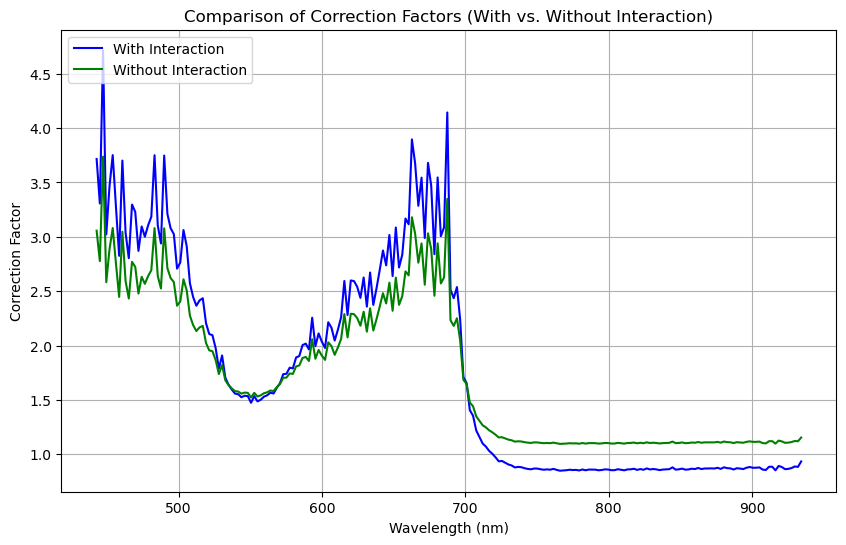

In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_correction_factors_comparison(wavelengths, correction_factors_with, correction_factors_without, title):
    plt.figure(figsize=(10, 6))
    plt.plot(wavelengths, correction_factors_with, label='With Interaction', color='blue')
    plt.plot(wavelengths, correction_factors_without, label='Without Interaction', color='green')
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Correction Factor')
    plt.title(title)
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.show()

# Example usage of the function
plot_correction_factors_comparison(wavelengths_trimmed, avg_correction_factors, avg_correction_factors_without, 'Comparison of Correction Factors (With vs. Without Interaction)')


def save_to_csv(data_1, data_2, data_3, filename):
    # Create a DataFrame with the data
    data = {
        'Wavelength (nm)': data_1,
        'Correction Factor (With Interaction)': data_2,
        'Correction Factor (Without Interaction)': data_3
    }
    df = pd.DataFrame(data)
    
    # Save the DataFrame to a CSV file
    df.to_csv(filename, index=False)
    print(f'Data has been saved to {filename}')

# # Corrected function call with the right file path
# save_to_csv(wavelengths_trimmed, avg_correction_factors, avg_correction_factors_without, 'C:/Users/Say70/OneDrive - Mississippi State University/Desktop/UAS data collection/SurajTest/New/correction_factors_comparison_water_4pm.csv')


In [70]:
# import matplotlib.pyplot as plt

# def plot_predicted_reference_comparison(wavelengths, avg_observed, predicted_with, predicted_without, title):
#     plt.figure(figsize=(10, 6))
#     plt.plot(wavelengths, avg_observed, label='Observed', color='red')
#     plt.plot(wavelengths, predicted_with, label='With Interaction', color='blue')
#     plt.plot(wavelengths, predicted_without, label='Without Interaction', color='green')
#     plt.xlabel('Wavelength (nm)')
#     plt.ylabel('Predicted Reflectance')
#     plt.title(title)
#     plt.legend(loc='upper left')
#     plt.grid(True)
#     plt.show()

# # Example usage of the function
# plot_predicted_reference_comparison(wavelengths_trimmed,avg_observed, avg_observed*avg_correction_factors, avg_observed*avg_correction_factors_without, 'Comparison of Predicted Reflectance (With vs. Without Interaction)')



# def save_to_csv(data_1, data_2, data_3, data_4 , filename):
#     # Create a DataFrame with the data
#     data = {
#         'Wavelength (nm)': data_1,
#         'Observed reflect': data_2,
#         'BRDF reflect(With Interaction)': data_3,
#         'BRDF reflect (Without Interaction)': data_4
#     }
#     df = pd.DataFrame(data)
    
#     # Save the DataFrame to a CSV file
#     df.to_csv(filename, index=False)
#     print(f'Data has been saved to {filename}')

# # Corrected function call with the right file path
# save_to_csv(wavelengths_trimmed, avg_observed, avg_observed*avg_correction_factors,avg_observed*avg_correction_factors_without, 'C:/Users/Say70/OneDrive - Mississippi State University/Desktop/UAS data collection/SurajTest/New/Reflect_comparison_water_4pm.csv')






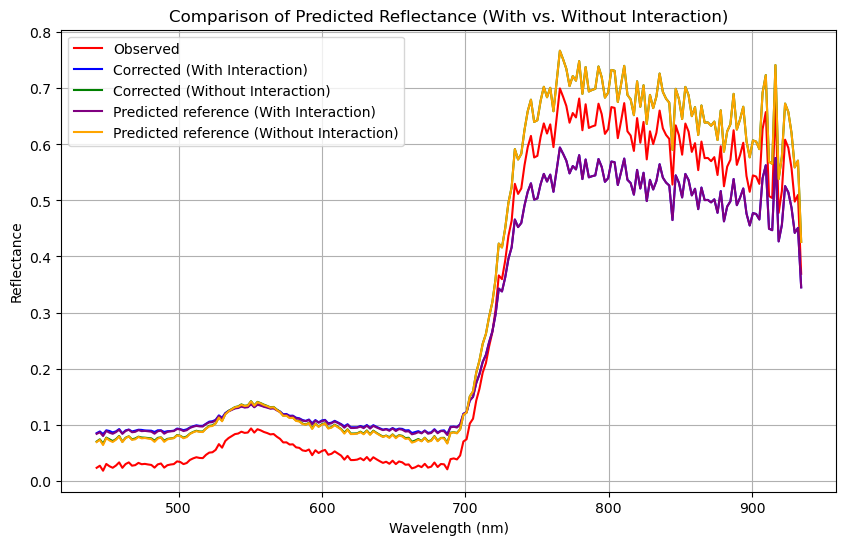

In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import least_squares

# Assuming previous code here to define variables

# Function to save data to CSV
def save_to_csv(data_1, data_2, data_3, data_4, data_5, data_6, filename):
    # Create a DataFrame with the data
    data = {
        'Wavelength (nm)': data_1,
        'Observed reflect': data_2,
        'BRDF reflect (With Interaction)': data_3,
        'BRDF reflect (Without Interaction)': data_4,
        'Predicted Standard (With Interaction)': data_5,
        'Predicted Standard (Without Interaction)': data_6
    }
    df = pd.DataFrame(data)
    
    # Save the DataFrame to a CSV file
    df.to_csv(filename, index=False)
    print(f'Data has been saved to {filename}')

# Define the plotting function
def plot_predicted_standard_comparison(wavelengths, avg_observed, corrected_with, corrected_without, predicted_with, predicted_without, title):
    plt.figure(figsize=(10, 6))
    plt.plot(wavelengths, avg_observed, label='Observed', color='red')
    plt.plot(wavelengths, corrected_with, label='Corrected (With Interaction)', color='blue')
    plt.plot(wavelengths, corrected_without, label='Corrected (Without Interaction)', color='green')
    plt.plot(wavelengths, predicted_with, label='Predicted reference (With Interaction)', color='purple')
    plt.plot(wavelengths, predicted_without, label='Predicted reference (Without Interaction)', color='orange')
    
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Reflectance')
    plt.title(title)
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.show()


# Average predicted standard reflectance
avg_predicted_standard_with_interaction = np.nanmean(predicted_standard, axis=0)
avg_predicted_standard_without_interaction = np.nanmean(predicted_standard_without, axis=0)


# save_to_csv(
#     wavelengths_trimmed,
#     avg_observed,
#     avg_observed * avg_correction_factors,
#     avg_observed * avg_correction_factors_without,
#     avg_predicted_standard_with_interaction,
#     avg_predicted_standard_without_interaction,
#     'C:/Users/Say70/OneDrive - Mississippi State University/Desktop/UAS data collection/SurajTest/New/Reflect_comparison_water_4pm.csv'
# )




# Plot the comparison
plot_predicted_standard_comparison(
    wavelengths_trimmed,
    avg_observed,
    avg_observed * avg_correction_factors,            # Corrected (With Interaction)
    avg_observed * avg_correction_factors_without,    # Corrected (Without Interaction)
    avg_predicted_standard_with_interaction,          # Predicted Standard (With Interaction)
    avg_predicted_standard_without_interaction,       # Predicted Standard (Without Interaction)
    'Comparison of Predicted Reflectance (With vs. Without Interaction)'
)


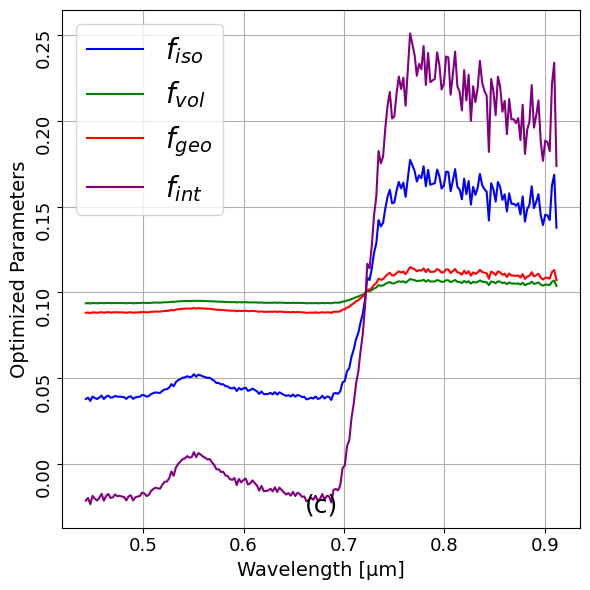

Plot values saved successfully to: C:/Users/Say70/OneDrive - Mississippi State University/Desktop/UAS data collection/SurajTest/New/veg_4pm.eps


In [77]:
import matplotlib.pyplot as plt
import numpy as np

output_directory = 'C:/Users/Say70/OneDrive - Mississippi State University/Desktop/UAS data collection/SurajTest/New/'

# Calculate the average optimized parameters for each wavelength
avg_optimized_params_per_wavelength_with = np.mean(optimized_params_per_sample, axis=0)
avg_optimized_params_per_wavelength_without = np.mean(optimized_params_per_sample_without, axis=0)

# Parameter names for 'with interaction' (5 parameters) and 'without interaction' (3 parameters)
param_names_with = ['$f_{iso}$', '$f_{vol}$', '$f_{geo}$', '$f_{int}$']
param_names_without = ['f_iso', 'f_vol', 'f_geo']
colors_with = ['blue', 'green', 'red', 'purple', 'orange']
colors_without = ['blue', 'green', 'red']



# Plot the data from all three CSVs
plt.figure(figsize=(6, 6))
# Plot for parameters with interaction (5 parameters)
for param_idx, param_name in enumerate(param_names_with):
    plt.plot(wavelengths_trimmed[:-10]/1000, avg_optimized_params_per_wavelength_with[:, param_idx][:-10], label=f'{param_name}', color=colors_with[param_idx])

plt.xlabel('Wavelength [µm]',fontsize=14)
plt.ylabel('Optimized Parameters',fontsize=14)
plt.legend(loc='upper left', fontsize=20)
#plt.legend(loc='upper left', bbox_to_anchor=(0.75, 0.95), fontsize=14)
plt.grid(True)
plt.tick_params(axis='both', labelsize=13)
plt.yticks(rotation=90)
plt.text(0.5, 0.02, '(c)', transform=plt.gca().transAxes, fontsize=18, 
         verticalalignment='bottom', horizontalalignment='center', color='black')
# Adjust layout to avoid overlap
plt.tight_layout()



# output_directory = 'C:/Users/Say70/OneDrive - Mississippi State University/Desktop/SPIE/GRSL/'
#offset_plot_path = f'{output_directory}op_veg_1pm.png'
#plt.savefig(offset_plot_path, dpi=600)  # Save with high resolution

plt.show()


# Prepare data for CSV
data_for_csv = {"Wavelength [µm]": wavelengths_trimmed[:-10] / 1000}
for param_idx, param_name in enumerate(param_names_with):
    data_for_csv[param_name] = avg_optimized_params_per_wavelength_with[:, param_idx][:-10]

# Create a DataFrame
df_plot_values = pd.DataFrame(data_for_csv)

# Save to CSV
csv_path = f'{output_directory}veg_4pm.eps'
df_plot_values.to_csv(csv_path, index=False)
print(f"Plot values saved successfully to: {csv_path}")


In [200]:

import pandas as pd

# Assuming `wavelengths_trimmed` and `avg_optimized_params_per_wavelength_with` are defined
# Trim the last 10 values of wavelengths and parameters as in the plot
wavelengths_trimmed_for_csv = wavelengths_trimmed[:-10] / 1000  # Convert to µm
params_trimmed_for_csv = avg_optimized_params_per_wavelength_with[:-10, :]  # Exclude last 10 rows

# Create a dictionary for the DataFrame
data_dict = {'Wavelength (µm)': wavelengths_trimmed_for_csv}

# Add each parameter as a column in the dictionary
for param_idx, param_name in enumerate(param_names_with):
    data_dict[param_name] = params_trimmed_for_csv[:, param_idx]

# Create a pandas DataFrame
df = pd.DataFrame(data_dict)

# Save the DataFrame to a CSV file
csv_file_path = 'C:/Users/Say70/OneDrive - Mississippi State University/Desktop/UAS data collection/SurajTest/op_water_4pm.csv'
df.to_csv(csv_file_path, index=False)

print(f"Data has been saved to {csv_file_path}")

Data has been saved to C:/Users/Say70/OneDrive - Mississippi State University/Desktop/UAS data collection/SurajTest/op_water_4pm.csv


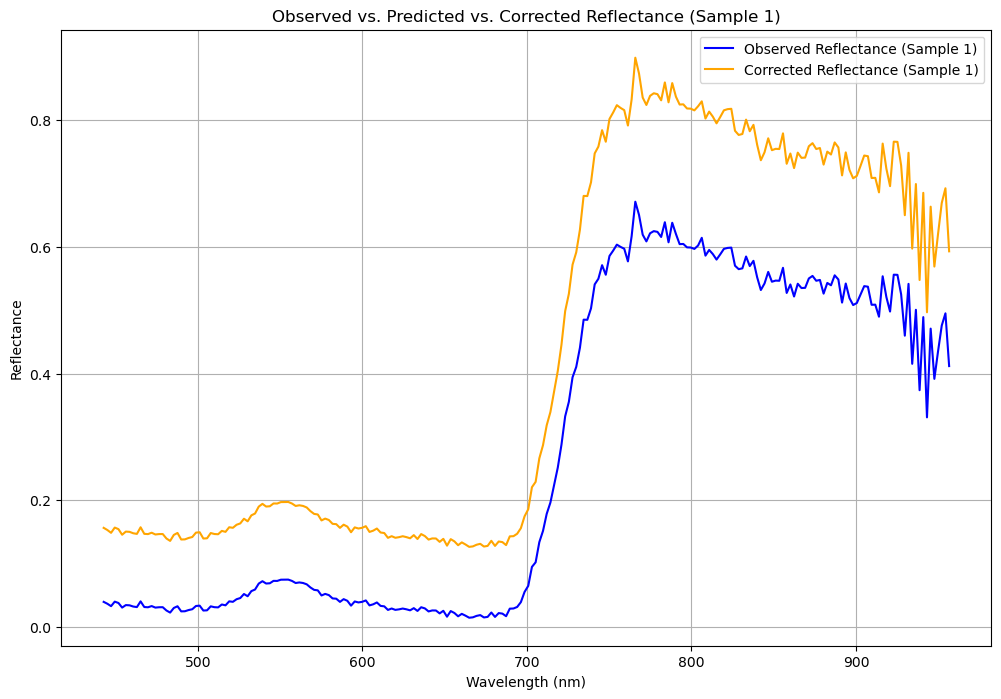

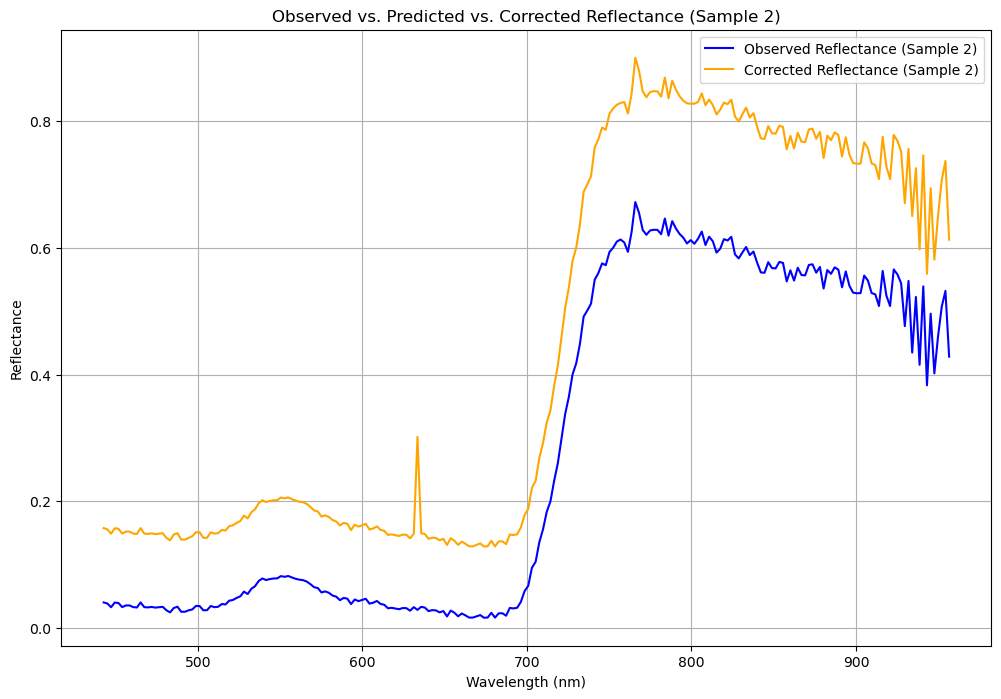

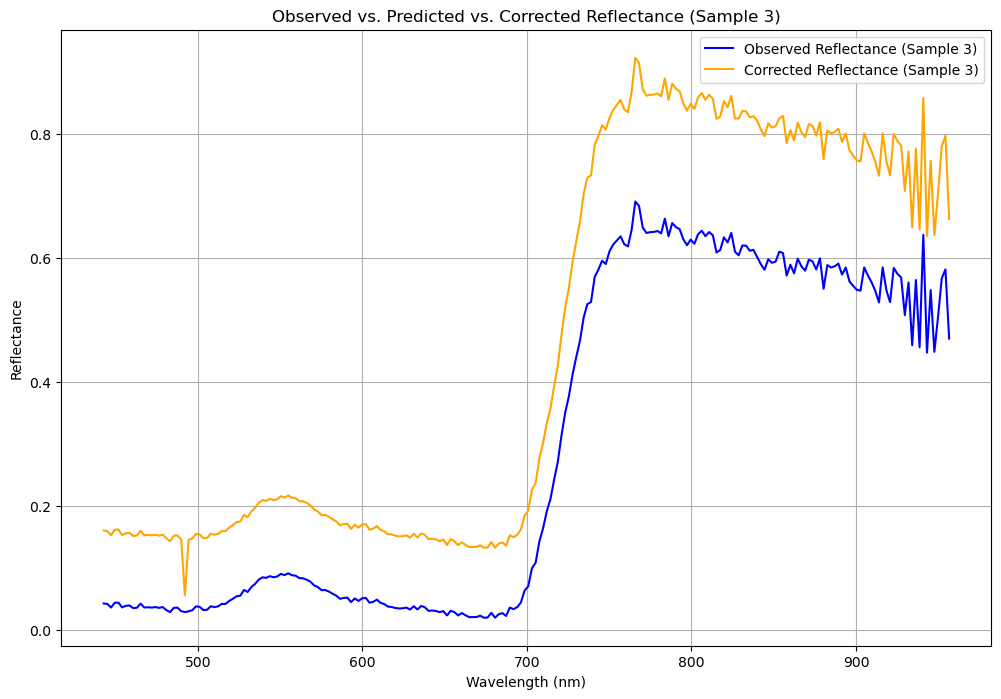

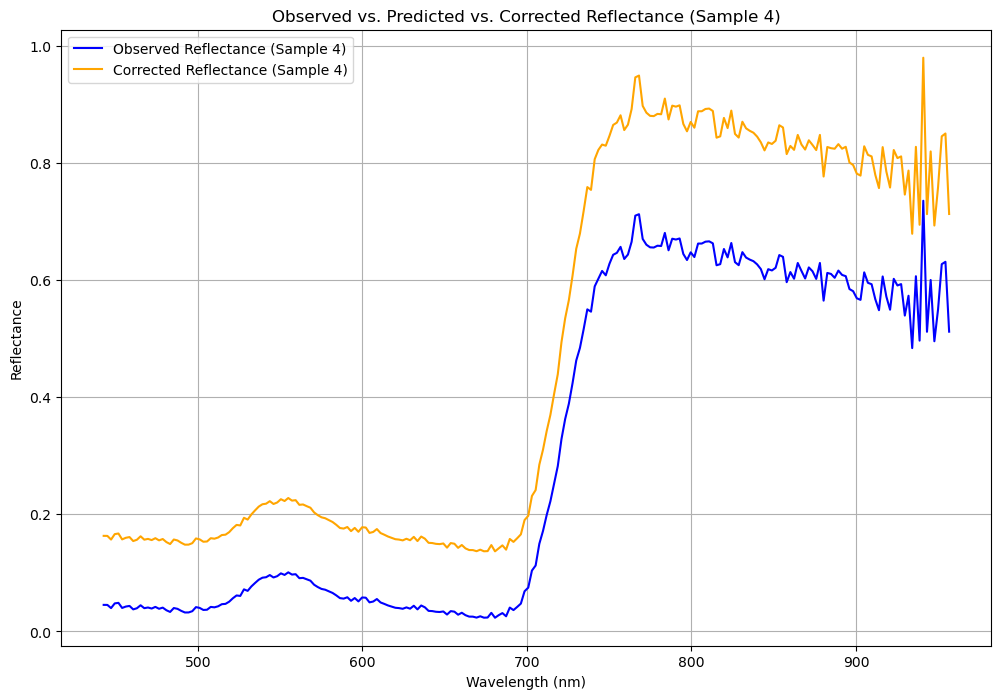

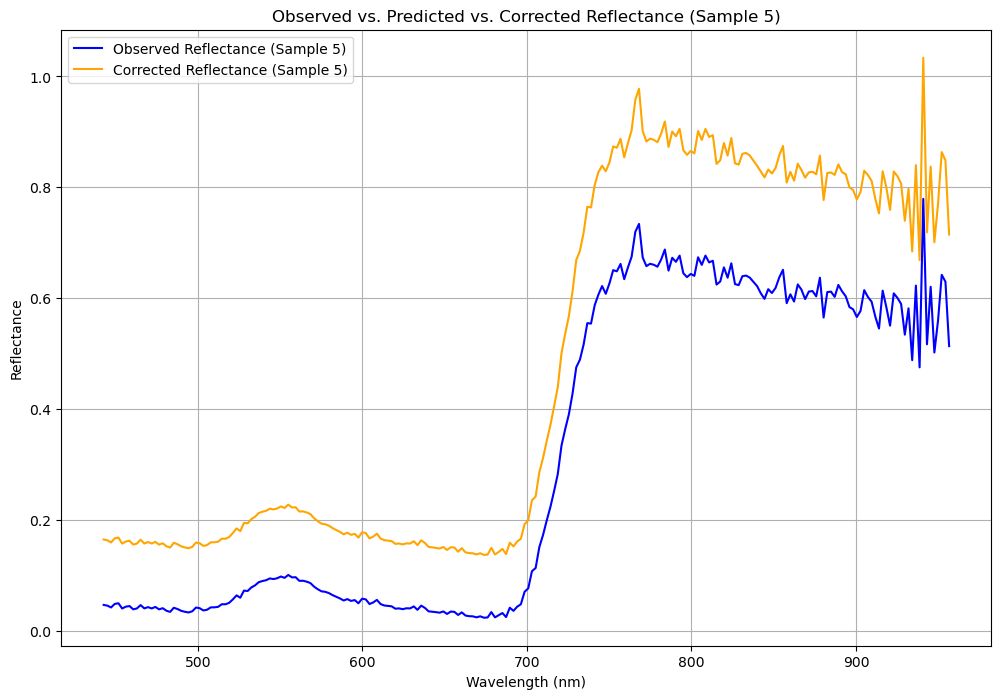

In [33]:
# Initialize an array to store corrected reflectance values
corrected_reflectance_values = np.zeros((num_samples, len(wavelengths)))

# Calculate corrected reflectance by multiplying observed reflectance with correction factor
for i in range(num_samples):  # For each sample
    for j in range(len(wavelengths)):  # For each wavelength
        # Check if the correction factor is valid (not NaN)
        if not np.isnan(correction_factors[i, j]):
            corrected_reflectance_values[i, j] = reflectivity_veg[i, j] * correction_factors[i, j]
        else:
            corrected_reflectance_values[i, j] = np.nan  # Handle cases with NaN correction factors

# Loop through all samples and plot the observed reflectance, corrected reflectance, and predicted reflectance
for i in range(num_samples):  # Loop for 10 samples
    plt.figure(figsize=(12, 8))
    #plt.plot(wavelengths, predicted_reflectance_values_standard[i, :], label=f'Predicted Reflectance (Standard, Sample {i+1})', color='green', linestyle='--')
    #plt.plot(wavelengths, predicted_reflectance_values_reference[i, :], label=f'Predicted Reflectance (Reference, Sample {i+1})', color='red', linestyle='--')
    plt.plot(wavelengths, reflectivity_veg[i, :], label=f'Observed Reflectance (Sample {i+1})', color='blue')
    plt.plot(wavelengths, corrected_reflectance_values[i, :], label=f'Corrected Reflectance (Sample {i+1})', color='orange')
    plt.title(f'Observed vs. Predicted vs. Corrected Reflectance (Sample {i+1})')
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Reflectance')
    plt.legend()
    plt.grid(True)
    plt.show()


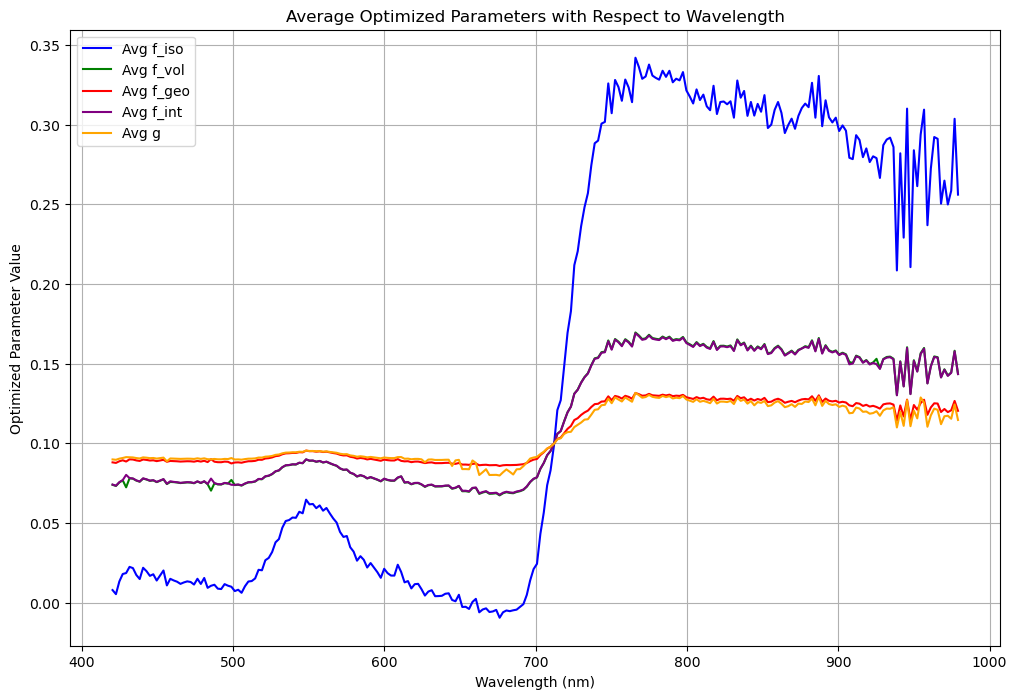

In [25]:
# # # Print or save average parameters
# # for i in range(len(wavelengths)):
# #     print(f"Wavelength: {wavelengths[i]} nm")
# #     print(f"Average f_iso: {average_f_iso[i]}")
# #     print(f"Average f_vol: {average_f_vol[i]}")
# #     print(f"Average f_geo: {average_f_geo[i]}")
# #     print(f"Average f_int: {average_f_int[i]}")
# #     print(f"Average g: {average_g[i]}")
# #     print()

# # Plotting the scatter plot and fitted line for each parameter
# plt.figure(figsize=(12, 8))
# plt.scatter(wavelengths, average_f_iso, label='f_iso (Data)', color='blue', alpha=0.6)
# # f_vol
# plt.scatter(wavelengths, average_f_vol, label='f_vol (Data)', color='green', alpha=0.6)
# # f_geo
# plt.scatter(wavelengths, average_f_geo, label='f_geo (Data)', color='purple', alpha=0.6)
# # f_int
# plt.scatter(wavelengths, average_f_int, label='f_int (Data)', color='orange', alpha=0.6)
# # g
# plt.scatter(wavelengths, average_g , label='g (Data)', color='magenta', alpha=0.6)
# plt.title('g vs. Wavelengths')
# plt.xlabel('Wavelength (nm)')
# plt.ylabel('g Value')
# plt.legend()
# plt.grid(True)

# plt.tight_layout()
# plt.show()

# Calculate the average of optimized parameters across all samples for each wavelength
avg_optimized_params_per_wavelength = np.mean(optimized_params_per_sample, axis=0)  # Shape (num_wavelengths, num_params)

# Plot the average of each optimized parameter with respect to wavelength
plt.figure(figsize=(12, 8))

# Assuming optimized_params has 5 parameters (f_iso, f_vol, f_geo, f_int, g)
param_names = ['f_iso', 'f_vol', 'f_geo', 'f_int', 'g']
colors = ['blue', 'green', 'red', 'purple', 'orange']

# Loop over each parameter and plot it
for param_idx, param_name in enumerate(param_names):
    plt.plot(wavelengths_trimmed, avg_optimized_params_per_wavelength[:, param_idx], 
             label=f'Avg {param_name}', color=colors[param_idx])

plt.title('Average Optimized Parameters with Respect to Wavelength')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Optimized Parameter Value')
plt.legend()
plt.grid(True)
plt.show()



In [56]:
import numpy as np

# Ross-Thick Kernel (volume scattering)
def ross_thick_kernel(theta_s, theta_v, phi):
    theta_s = np.radians(theta_s)
    theta_v = np.radians(theta_v)
    phi = np.radians(phi)

    cos_theta_s = np.cos(theta_s)
    cos_theta_v = np.cos(theta_v)
    sin_theta_s = np.sin(theta_s)
    sin_theta_v = np.sin(theta_v)

    cos_phi = np.cos(phi)
    cos_psi = cos_theta_s * cos_theta_v + sin_theta_s * sin_theta_v * cos_phi

    psi = np.arccos(np.clip(cos_psi, -1, 1))  # Clip to avoid floating-point errors

    return ((np.pi / 2 - psi) * np.cos(psi) + np.sin(psi)) / (cos_theta_s + cos_theta_v)


# Li-Sparse Kernel (geometric scattering)
def li_sparse_kernel(theta_s, theta_v, phi, r=1):
    theta_s = np.radians(theta_s)
    theta_v = np.radians(theta_v)
    phi = np.radians(phi)

    cos_theta_s = np.cos(theta_s)
    cos_theta_v = np.cos(theta_v)
    sin_theta_s = np.sin(theta_s)
    sin_theta_v = np.sin(theta_v)

    D = np.sqrt(np.tan(theta_s)**2 + np.tan(theta_v)**2 - 2 * np.tan(theta_s) * np.tan(theta_v) * np.cos(phi))
    cos_t = r / np.sqrt(1 + D**2)
    t = np.arccos(np.clip(cos_t, -1, 1))  # Clip to avoid floating-point errors

    O = (1 + np.cos(t)) / (cos_theta_s * cos_theta_v)
    
    return O - 1  # The Li sparse kernel

# Function to compute BRDF correction
def brdf_correction(theta_s, theta_v, phi, f_iso, f_vol, f_geo):
    K_vol = ross_thick_kernel(theta_s, theta_v, phi)
    K_geo = li_sparse_kernel(theta_s, theta_v, phi)
    
    # BRDF model
    brdf = f_iso + f_vol * K_vol + f_geo * K_geo
    return brdf

# Example usage
actual_theta_s = 43.38571872432771  # Solar zenith angle in degrees
actual_theta_v = 0  # View zenith angle in degrees
actual_phi = 100.92949976490078      # Relative azimuth angle in degrees


standard_theta_s = 0  # Solar zenith angle in degrees
standard_theta_v = 0  # View zenith angle in degrees
standard_phi = 0     # Relative azimuth angle in degrees

# Coefficients for the BRDF model (based on a dataset or fitting)
f_iso = 0.1   # Isotropic coefficient
f_vol = 0.5   # Volume scattering coefficient (Ross-thick)
f_geo = 0.3   # Geometric scattering coefficient (Li-sparse)

# Perform BRDF correction
actual_brdf_value = brdf_correction(actual_theta_s, actual_theta_v , actual_phi, f_iso, f_vol, f_geo)

standard_brdf_value = brdf_correction(standard_theta_s, standard_theta_v , standard_phi, f_iso, f_vol, f_geo)

print(f"BRDF actual Value: {actual_brdf_value}")
print(f"BRDF standard Value: {standard_brdf_value}")

corrrection = standard_brdf_value/actual_brdf_value

print(f"BRDF Correction Value: {corrrection}")

BRDF actual Value: 0.8829076177325503
BRDF standard Value: 0.792699081698724
BRDF Correction Value: 0.8978278879669241


In [57]:
from scipy.optimize import curve_fit

# Define your observed data (angles and reflectance)
theta_s_data = np.array([30, 40, 50])  # Solar zenith angles (in degrees)
theta_v_data = np.array([10, 20, 30])  # View zenith angles (in degrees)
phi_data = np.array([45, 50, 60])      # Relative azimuth angles (in degrees)
reflectance_data = np.array([0.3, 0.35, 0.32])  # Measured reflectance

# BRDF model function for curve fitting
def brdf_model(params, theta_s, theta_v, phi):
    f_iso, f_vol, f_geo = params
    return brdf_correction(theta_s, theta_v, phi, f_iso, f_vol, f_geo)

# Initial guess for the coefficients [f_iso, f_vol, f_geo]
initial_guess = [0.1, 0.5, 0.3]

# Perform non-linear least squares fitting to find the optimal parameters
popt, _ = curve_fit(brdf_model, (theta_s_data, theta_v_data, phi_data), reflectance_data, p0=initial_guess)

# Extract fitted parameters
f_iso_opt, f_vol_opt, f_geo_opt = popt
print(f"Optimized coefficients: f_iso={f_iso_opt}, f_vol={f_vol_opt}, f_geo={f_geo_opt}")

# BRDF for the observed geometry
theta_s_obs = 30  # Solar zenith angle for observed geometry
theta_v_obs = 10  # View zenith angle for observed geometry
phi_obs = 45      # Relative azimuth angle for observed geometry
brdf_observed = brdf_correction(theta_s_obs, theta_v_obs, phi_obs, f_iso_opt, f_vol_opt, f_geo_opt)

# BRDF for the reference geometry (θ_s=0°, θ_v=0°, φ=0°)
theta_s_ref = 0  # Solar zenith angle for reference geometry
theta_v_ref = 0  # View zenith angle for reference geometry
phi_ref = 0      # Relative azimuth angle for reference geometry
brdf_reference = brdf_correction(theta_s_ref, theta_v_ref, phi_ref, f_iso_opt, f_vol_opt, f_geo_opt)

# Compute the correction factor
correction_factor = brdf_reference / brdf_observed
print(f"Correction Factor: {correction_factor}")

# Correct the reflectance
corrected_reflectance = reflectance_data * correction_factor
print(f"Corrected Reflectance: {corrected_reflectance}")


Optimized coefficients: f_iso=-12.059794090072467, f_vol=12.059717761608706, f_geo=0.29958201235641296
Correction Factor: 1.0508742646809053
Corrected Reflectance: [0.31526228 0.36780599 0.33627976]


C:\Users\Say70\AppData\Local\Temp\ipykernel_14744\1161540589.py:18: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(brdf_model, (theta_s_data, theta_v_data, phi_data), reflectance_data, p0=initial_guess)


In [58]:
import numpy as np

# Define the existing Ross-Li kernels
def ross_kernel(theta_s, theta_v, phi):
    # Volumetric scattering kernel (Ross-Thick model example)
    return (np.pi - phi) * np.sin(theta_s) * np.sin(theta_v) + np.cos(theta_s) * np.cos(theta_v)

def li_kernel(theta_s, theta_v, phi):
    # Geometric scattering kernel (Li-Sparse model example)
    return (1 / np.pi) * (theta_s - theta_v) / (theta_s + theta_v)

# New Surface Scattering kernel (specular reflection)
def surface_scattering_kernel(theta_s, theta_v, phi):
    # Example using a simple specular term (can be replaced with more complex models)
    return np.exp(-((theta_s - theta_v)**2) / (2 * np.pi**2))

# Interaction term combining volumetric and geometric scattering
def interaction_kernel(theta_s, theta_v, phi):
    return ross_kernel(theta_s, theta_v, phi) * li_kernel(theta_s, theta_v, phi)

# Modified BRDF model with additional surface scattering and interaction scattering terms
def modified_brdf_model(theta_s, theta_v, phi, f_iso, f_vol, f_geo, f_spec, f_int):
    return (f_iso +
            f_vol * ross_kernel(theta_s, theta_v, phi) +
            f_geo * li_kernel(theta_s, theta_v, phi) +
            f_spec * surface_scattering_kernel(theta_s, theta_v, phi) +
            f_int * interaction_kernel(theta_s, theta_v, phi))

# Example angles
theta_s = np.radians(30)  # Solar zenith angle
theta_v = np.radians(10)  # Viewing zenith angle
phi = np.radians(20)      # Relative azimuth angle

# Example coefficients
f_iso, f_vol, f_geo, f_spec, f_int = 0.1, 0.2, 0.3, 0.05, 0.15

# Compute modified BRDF value
brdf_value = modified_brdf_model(theta_s, theta_v, phi, f_iso, f_vol, f_geo, f_spec, f_int)
print("BRDF value:", brdf_value)


BRDF value: 0.4426532260194572
